# Analysing and Predicting Public Perception on Social Media

Understanding public brand perception can be a challenge.  With the rise of social media, good data on pulic opinion about specific topics and brands is widely available. Twitter is the perfect platform for this.  By scrapping twitter data we will try to implement sentiment analysis on particular brands and topics, we will then implement a Time Series model and train it on past sentiment trends to help it predict future sentiment trajectory.  (Bitcoin, Nike vs Adidas - Twitter sentiment trend analysis + prediction)

> Importing our standard libraries, the autoreload module..

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
from os import path
sys.path.append("twint/")

# 1 . Scrapping Twitter with TWINT

We'll begin by scrapping Twitter using the TWINT module, since Twitter's standard search API is very limited. The TWINT modules allows us to search for target tweets by keyword, within a date range, and much more almost without limitations, the enitre Twittersphere is now available to us.  We can then perform sentiment analysis on specific tweets.
  
We've installed TWINT through the command line and appended it to our system path in the cell above.  Next, we will import the module and set up its configuration and start running queries.  
  

In [3]:
# load TWINT and set up its configuration
import twint
c = twint.Config()

In [4]:
# Solve compatibility issues with notebooks and RunTime errors.
import nest_asyncio
nest_asyncio.apply()

In [5]:
c.Search = "bitcoin"
c.Limit = 1 # results are returned in blocks of 20 tweets, 1 here means 20
c.Pandas = True
twint.run.Search(c)

1156593828905832448 2019-07-31 11:53:51 EDT <Infanteangelo> Sonhei com um 🐎 encilhado hoje! Nele tinha uma faixa escrita assim:  Operação B&B Vende BIDI11 Compra Bitcoin #LongShot #Compranabaixa #vendenaalta #bitcoin #criptomonedas #bidi11 📈
1156593813504348161 2019-07-31 11:53:48 EDT <CryptoGirl_News> America Hasn’t Done This in 10 Years – And It’s Fire for Bitcoin  https://ift.tt/2YBtw5w  I love rewards or tips.  https://ift.tt/2ZLQRhQ  pic.twitter.com/qPOLTrs29q
1156593808123006977 2019-07-31 11:53:46 EDT <Remi_Vladuceanu> Weekly Digest: Bitcoin Price Inaction, India Ban, and Sanction Busting ➡️ https://tribetica.com/weekly-digest-bitcoin-price-inaction-india-ban-and-sanction-busting/ … 🗺️ ▶️ http://reddit.com/r/tribetica  #last7daysnews #Bitcoin #blockchain #crypto pic.twitter.com/4vqBF2MPTQ
1156593791811428352 2019-07-31 11:53:43 EDT <MidwestHedgie> I would trade the Bitcoin for tits like his.
1156593770173009920 2019-07-31 11:53:37 EDT <btc_update> Bitcoin Miner Maker Canaan Conf

### Great!
> We have tweets being output as our result!  Now let's format this output into a dataframe we can work with

In [6]:
def available_columns():
    return twint.output.panda.Tweets_df.columns

def twint_to_pandas(columns):
    return twint.output.panda.Tweets_df[columns]

In [7]:
# see what columns are available
available_columns()

Index(['cashtags', 'conversation_id', 'created_at', 'date', 'day', 'geo',
       'hashtags', 'hour', 'id', 'link', 'name', 'near', 'nlikes', 'nreplies',
       'nretweets', 'place', 'quote_url', 'retweet', 'search', 'timezone',
       'tweet', 'user_id', 'user_id_str', 'username'],
      dtype='object')

In [8]:
# create Pandas dataframe with desired columns
df = twint_to_pandas(['conversation_id', 'created_at', 'id', 'user_id', 'username', 'tweet', 'hashtags', 'date', 'day', 'nlikes', 'nretweets'])
print(df.shape)
df.head()

(20, 11)


,conversation_id,created_at,id,user_id,username,tweet,hashtags,date,day,nlikes,nretweets
0,1156593828905832448,1564588431000,1156593828905832448,222974462,Infanteangelo,Sonhei com um 🐎 encilhado hoje! Nele tinha uma...,"[#longshot, #compranabaixa, #vendenaalta, #bit...",2019-07-31 11:53:51,2,0,0
1,1156593813504348161,1564588428000,1156593813504348161,4060615408,CryptoGirl_News,America Hasn’t Done This in 10 Years – And It’...,[],2019-07-31 11:53:48,2,0,0
2,1156593808123006977,1564588426000,1156593808123006977,26735842,Remi_Vladuceanu,"Weekly Digest: Bitcoin Price Inaction, India B...","[#last7daysnews, #bitcoin, #blockchain, #crypto]",2019-07-31 11:53:46,2,0,0
3,1156567982455316480,1564588423000,1156593791811428352,29748111,MidwestHedgie,I would trade the Bitcoin for tits like his.,[],2019-07-31 11:53:43,2,0,0
4,1156593770173009920,1564588417000,1156593770173009920,3092694229,btc_update,Bitcoin Miner Maker Canaan Confidentially File...,"[#bitcoin, #crypto, #blockchain, #btc, #news, ...",2019-07-31 11:53:37,2,0,0


### Success!
> We now have a data frame with 20 tweets all containing the keyword "bitcoin", along with some additional information about the tweets

> Now let's make our code a bit more modular so that we can run constant queries

In [9]:
# Disable annoying printing
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [10]:
# test Twitter scraping
def get_tweets(search_term, limit=100):
    c = twint.Config()
    c.Search = search_term
    c.Limit = limit
    c.Pandas = True
    c.Pandas_clean = True
    
    result_columns = ['id', 'username', 'tweet', 'hashtags', 'date', 'day', 'nlikes', 'nretweets']
    with HiddenPrints():
        print(twint.run.Search(c))
    return twint.output.panda.Tweets_df[result_columns]

In [11]:
bitcoin_tweets = get_tweets("bitcoin", limit=10000)
print(bitcoin_tweets.shape)
bitcoin_tweets.head()

(10004, 8)


,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,1154070862536028161,maksimmerili,Long/Short Bitcoin & altcoin volatility with u...,[],2019-07-24 12:48:29,5,0,0
1,1154070855380623360,RadsickTrrance,#Bitcoin Price Shuns Volatility as Analysts Wa...,"[#bitcoin, #crypto]",2019-07-24 12:48:28,5,0,0
2,1154070832827813890,TurgayMutlucan,"Bitcoin bu, her an herşey olabilir!",[],2019-07-24 12:48:22,5,0,0
3,1154070829812125707,WallyGideon,New video by Legit TV: Why Coincola is the bes...,[],2019-07-24 12:48:22,5,0,0
4,1154070822828617729,cryptosnarf,When real bitcoin back,[],2019-07-24 12:48:20,5,0,0


In [12]:
adidas_tweets = get_tweets("adidas", limit=10000)
print(adidas_tweets.shape)
adidas_tweets.head()

(10016, 8)


,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,1154072907297054720,swerve1973,Classy combo! I had a Raleigh Burner and Adida...,[],2019-07-24 12:56:37,3,0,0
1,1154072900816662528,RoopGautam,"कभी नंगे पैर दौड़ना पड़ता था, क्योंकि जूते खरी...",[],2019-07-24 12:56:35,3,1,0
2,1154072900418359296,cinj00,Elite 8 game is a W!! We beat a tough CBC Elit...,[],2019-07-24 12:56:35,3,0,0
3,1154072890951819265,checkthekicks,http://rover.ebay.com/rover/1/711-53200-19255...,[#kidsshoes],2019-07-24 12:56:33,3,0,0
4,1154072886635880448,liberosans,i'm sick his entire wardrobe is different blac...,[],2019-07-24 12:56:32,3,0,0


In [13]:
adidas_tweets.tail()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
10011,1153716514215698432,New_preloved,{NP} Ada yang mau thread tas tas branded dari ...,[],2019-07-23 13:20:26,7,6,0
10012,1153716480917344258,Felipekrf,"Meninaaaas, chegaram os vestidos de moletom da...",[],2019-07-23 13:20:18,7,0,1
10013,1153716470469267458,giselamlopez,Adidas wow #daretocreate New adidas ad Dare ...,[#daretocreate],2019-07-23 13:20:16,7,0,0
10014,1153716458704310273,masterthegamerp,I like ADIDAS or Vans maybe?,[],2019-07-23 13:20:13,7,2,0
10015,1153716452496674816,steezy_jay__,They actually sell think about it it’s only we...,[],2019-07-23 13:20:11,7,0,0


In [14]:
nike_tweets = get_tweets("nike", limit=10000)
print(nike_tweets.shape)
nike_tweets.head()

(10000, 8)


,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,1154077508133933058,twanAthon,I’m glad he went to Jordan. That speaks volume...,[],2019-07-24 13:14:54,2,0,0
1,1154077437912866818,crackyspen,2009 Polo Jeans Perfect Circle/Godspeed The St...,[],2019-07-24 13:14:37,2,0,0
2,1154077431860551682,somto_jr,Nike shoes are better than adidas shoes,[],2019-07-24 13:14:36,2,0,0
3,1154077420665921536,alcarazpedro,la última de nike?,[],2019-07-24 13:14:33,2,0,0
4,1154077405717417988,FernandzCande,me calzo las Nike y me voy a caminar lejos con...,[],2019-07-24 13:14:29,2,0,0


# 2 . Testing the Vader Module for Sentiment Analysis

> first let's test out Vader on a simple line of text and analyze the results

In [ ]:
#!pip install vaderSentiment

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [12]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print('sentence: "{}"'.format(sentence))
    print('scores: {}'.format(str(score))) 
    return score['compound']

In [13]:
sentiment_analyzer_scores("Nike is the best.")

sentence: "Nike is the best."
scores: {'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.6369}


0.6369

> Pretty positive sentiment, how about...

In [14]:
sentiment_analyzer_scores("Nike is the BEST!")

sentence: "Nike is the BEST!"
scores: {'neg': 0.0, 'neu': 0.365, 'pos': 0.635, 'compound': 0.7371}


0.7371

> See the increase in positivity from .63 to .73

> Let's try another simple example

In [15]:
sentiment_analyzer_scores("Adidas sucks, but I like their sustainability initiative.")

sentence: "Adidas sucks, but I like their sustainability initiative."
scores: {'neg': 0.175, 'neu': 0.5, 'pos': 0.325, 'compound': 0.3612}


0.3612

> How about...

In [16]:
sentiment_analyzer_scores("Adidas is terrible!  I just hate all their designs, and that Kanye West line looked like clothing for homeless people.  I'll never buy Adidas, ever!")

sentence: "Adidas is terrible!  I just hate all their designs, and that Kanye West line looked like clothing for homeless people.  I'll never buy Adidas, ever!"
scores: {'neg': 0.239, 'neu': 0.68, 'pos': 0.081, 'compound': -0.7081}


-0.7081

> Now that we've tested Vader, let's apply it to our dataframes and see the overall sentiment in about 10,000 tweets on each topic/brand

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
def compound_score(tweet):
    return analyser.polarity_scores(tweet)['compound']

def overall_sentiment(df):
    df['sentiment_score'] = df['tweet'].apply(compound_score)
    return round(df['sentiment_score'].sum() / len(df['sentiment_score']), 2)

In [19]:
compound_score('Adidas is one of my FAV sports brands!')

0.6155

In [44]:
bitcoin_total_score = overall_sentiment(bitcoin_tweets)
print(f'The overall sentiment score for the "Bitcoin" related set of tweets is: {bitcoin_total_score}')
bitcoin_tweets.head(2)

The overall sentiment score for the "Bitcoin" related set of tweets is: 0.1


,id,username,tweet,hashtags,date,day,nlikes,nretweets,sentiment_score
0,1154070862536028161,maksimmerili,Long/Short Bitcoin & altcoin volatility with u...,[],2019-07-24 12:48:29,5,0,0,0.4184
1,1154070855380623360,RadsickTrrance,#Bitcoin Price Shuns Volatility as Analysts Wa...,"[#bitcoin, #crypto]",2019-07-24 12:48:28,5,0,0,-0.3612


> People are currently pretty neutral on Bitcoin, not surprising.

In [48]:
adidas_total_score = overall_sentiment(adidas_tweets)
print(f'The overall sentiment score for the "Adidas" related set of tweets is: {adidas_total_score}')
adidas_tweets.head(2)

The overall sentiment score for the "Adidas" related set of tweets is: 0.12


,id,username,tweet,hashtags,date,day,nlikes,nretweets,sentiment_score
0,1154072907297054720,swerve1973,Classy combo! I had a Raleigh Burner and Adida...,[],2019-07-24 12:56:37,3,0,0,0.4926
1,1154072900816662528,RoopGautam,"कभी नंगे पैर दौड़ना पड़ता था, क्योंकि जूते खरी...",[],2019-07-24 12:56:35,3,1,0,0.0000


> Notice how a foreign language gives us a sentiment score of 0 (neutral, but this ruins our averages!)  
> What if the foreign language contained characters from the English alphabet?  how would our scores be affected?

In [51]:
nike_total_score = overall_sentiment(nike_tweets)
print(f'The overall sentiment score for the "Nike" related set of tweets is: {nike_total_score}')
nike_tweets.head(2)

The overall sentiment score for the "Nike" related set of tweets is: 0.07


,id,username,tweet,hashtags,date,day,nlikes,nretweets,sentiment_score
0,1154077508133933058,twanAthon,I’m glad he went to Jordan. That speaks volume...,[],2019-07-24 13:14:54,2,0,0,0.7096
1,1154077437912866818,crackyspen,2009 Polo Jeans Perfect Circle/Godspeed The St...,[],2019-07-24 13:14:37,2,0,0,0.9396


> Adidas currently trumps Nike! Whaaaaaat?? look at Nike's first two sentiment scores

Though averaging the entire dataset may have played a true role in this, we're still pretty skeptical that Adidas had better sentiment ratings than Nike.  We can also see that all of our overall scores are pretty neutral... This is where Data Cleaning and preparing our tweets to be analyzed for sentiment will play a big role.  Additionally, the popularity of a tweet should be taken into account, tweets with a large number of 'likes' and many retweets should have a stronger effect on our overall score.  We will tackle this shortly.  

For now, let's understand that we will these sentiment scores to individually classify tweets into 5 classes:  
  
- 0 = negative	
- 1 = neutral_negative		
- 2 = neutral		
- 3 = neutral_positive	
- 4 = positive    

  
The scores will aslo be averaged per day, month, and year for trend visualizaiton purposes and for our Time Series analysis.  
We should aggregate and organize our tweet data accordingly

In [ ]:
# how can we take into account an average score for the day as well as the whole month
# we will want to visualize sentiment trends day by day as well as month by month over the year+

### Real Data
Let's note that before we apply Vader to our real data, there are multiple things we have to consider.  
Firsly, a considerable amount of data cleaning needs to be done on the tweets for the sentiment scores to be accurate and valuable.  In our example above, some tweets remain in foreign languages, so those sentiment scores are actually null to us, yet they still affect the overall average of compound score.  Additionally, some special characters may be throwing off the NLP implementation within Vader, and should be removed.  

Moving forward, we will keep these considerations and many more in mind, and generate the most accurate possible sentiment scores we can.  We will begin by aggragating our real data, keeping in mind our date ranges so to represent real time-linear data for our Time Series analysis.  We will then continue to Data Cleaning, and make sure our tweets are in perfect form before moving on to analysing sentiment with Vader. 

# 3 . Real Data Aggregation

We will now scrape Twitter for targeted tweets dating back to 2017 (2 and 1/2 + years in total).  We want these tweets aggragated monthly, and we will save each month of tweets in its own .json file inside our twitter_dataset directory.  We will then concactenate this data into a single dataframe for each topic/brand, representing the topic/brands' entire "recent" public Twitter data.

> We want popular and significant tweets - let's keep that in mind when scraping as well as when evaluating sentiment

> So ...  
- We will set TWINT's 'popular-tweets' option to True in order to retrieve only popular tweets  
- We will also use TWINT's 'lang' option to make sure we only retrieve tweets that are in English  
-  Finally, we will set 'since' amd 'until' to the approriate dates to retrive our tweets in a monthly fashion  

In [20]:
# slice our ~ 3 year time range into tuples of montlhy time ranges
import datetime
begin = '2017-01-01'
end = '2019-7-24'
month_ranges = []

dt_start = datetime.datetime.strptime(begin, '%Y-%m-%d')
dt_end = datetime.datetime.strptime(end, '%Y-%m-%d')
one_day = datetime.timedelta(1)
start_dates = [dt_start]
end_dates = []
today = dt_start

while today <= dt_end:
    #print(today)
    tomorrow = today + one_day
    if tomorrow.month != today.month:
        start_dates.append(tomorrow)
        end_dates.append(today)
    today = tomorrow

end_dates.append(dt_end)

for start, end in zip(start_dates,end_dates):
    month_ranges.append((start, end))
    
    
month_ranges

[(datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2017, 1, 31, 0, 0)),
 (datetime.datetime(2017, 2, 1, 0, 0), datetime.datetime(2017, 2, 28, 0, 0)),
 (datetime.datetime(2017, 3, 1, 0, 0), datetime.datetime(2017, 3, 31, 0, 0)),
 (datetime.datetime(2017, 4, 1, 0, 0), datetime.datetime(2017, 4, 30, 0, 0)),
 (datetime.datetime(2017, 5, 1, 0, 0), datetime.datetime(2017, 5, 31, 0, 0)),
 (datetime.datetime(2017, 6, 1, 0, 0), datetime.datetime(2017, 6, 30, 0, 0)),
 (datetime.datetime(2017, 7, 1, 0, 0), datetime.datetime(2017, 7, 31, 0, 0)),
 (datetime.datetime(2017, 8, 1, 0, 0), datetime.datetime(2017, 8, 31, 0, 0)),
 (datetime.datetime(2017, 9, 1, 0, 0), datetime.datetime(2017, 9, 30, 0, 0)),
 (datetime.datetime(2017, 10, 1, 0, 0), datetime.datetime(2017, 10, 31, 0, 0)),
 (datetime.datetime(2017, 11, 1, 0, 0), datetime.datetime(2017, 11, 30, 0, 0)),
 (datetime.datetime(2017, 12, 1, 0, 0), datetime.datetime(2017, 12, 31, 0, 0)),
 (datetime.datetime(2018, 1, 1, 0, 0), datetime.datetime(2

In [21]:
import json

In [22]:
# let's rewrite our get_tweets function, i will serve as the index of the month_range tuple
def get_real_data_tweets(search_term, i, limit=100):
    """
    scrappes Twitter for tweets within the specified date range
    makes sure month_ranges list is in memory and contains tuples of 2 dates ([0]=starting, [1]=ending)
    pass in a search term, returns Pandas dataframe
    """
    # real data mining
    c = twint.Config()
    c.Search = search_term
    c.Limit = limit
    c.Pandas = True
    c.Pandas_clean = True
    c.Lang = 'en'
    c.Since = str(month_ranges[i][0])[:10]
    c.Until = str(month_ranges[i][1])[:10]
    c.Popular_tweets = True
    c.Store_json = True

    result_columns = ['id', 'username', 'tweet', 'hashtags', 'date', 'day', 'nlikes', 'nretweets']
    with HiddenPrints():
        print(twint.run.Search(c))
    return twint.output.panda.Tweets_df[result_columns]

In [155]:
# let's test it for one month
january_2017_bitcoin_tweets = get_real_data_tweets('bitcoin', 0, limit=100000)
print(january_2017_bitcoin_tweets.shape)
january_2017_bitcoin_tweets.head()

CRITICAL:root:twint.output:checkData:copyrightedTweet


(4294, 8)


,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,826218195908456449,coindesk,The latest Bitcoin Price Index is 920.09 USD ...,[],2017-01-30 18:59:02,5,19,20
1,826216967724007425,sharkybit,Blythe Masters said #Bitcoin is bad because yo...,[#bitcoin],2017-01-30 18:54:10,1,31,15
2,826214708260765696,blockchain,A warning & important message to users & the #...,[#bitcoin],2017-01-30 18:45:11,2,41,48
3,826214582045728768,Steven_McKie,Just had a really awesome interview with @bala...,[],2017-01-30 18:44:41,2,21,6
4,826207612253458434,Xentagz,Stable #bitcoin price pic.twitter.com/ZlSiY8jb5d,[#bitcoin],2017-01-30 18:16:59,3,16,2


### Ok let's scrape our full recent Twitter dataset (~ 3 years) for "bitcoin", "adidas", and "nike"

In [23]:
def create_dataset(search_term):
    """
    gets monthly .json files and dataframes for tweets dating back to January 2017
    concats them into one large dataframe 
    please pass in a search term
    """    
    dataframes={}
    
    for i, month in enumerate(month_ranges):
        key = str(month[0])[:4] + '_' + str(month[0])[5:7] + '_' + search_term + '_tweets'
        dataframes[key] = get_real_data_tweets(search_term, i,  limit=100000)
        dataframes[key].sort_values(by=['date'], inplace=True, ascending=True)
        dataframes[key].to_json(str(month[0])[:4] + '_' + str(month[0])[5:7] + '_' + search_term + '_tweets.json')
        
    df = pd.concat([v for v in dataframes.values()])
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)

    print(df.shape)
    return df, dataframes

In [21]:
bitcoin_dataset, bitcoin_dataframes = create_dataset('bitcoin')

CRITICAL:root:twint.output:checkData:copyrightedTweet
CRITICAL:root:twint.output:checkData:copyrightedTweet
CRITICAL:root:twint.output:checkData:copyrightedTweet


(285541, 8)


In [22]:
bitcoin_dataset.head()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,815422325629796353,calestous,#Bitcoin Ends 2016 as the Top Currency as It N...,[#bitcoin],2017-01-01 00:00:06,6,5,10
1,815423070919921664,Satoshi_N_,Happy New Year @Bitcoin.,[],2017-01-01 00:03:04,1,44,18
2,815423326332088320,RedditBTC,"""It's a HUGE deal. It's a HUGE, HUGE, HUGE dea...",[],2017-01-01 00:04:05,2,8,2
3,815425340420001792,TigoCTM,Crypto Currency #Bitcoin #Dash #Crypto http:...,"[#bitcoin, #dash, #crypto]",2017-01-01 00:12:05,7,17,21
4,815426865561210880,DollarVigilante,Trends Generated By Jubilee 2016 Will Continue...,"[#bitcoin, #investing]",2017-01-01 00:18:09,4,15,7


In [23]:
bitcoin_dataset.tail()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
285536,1153794367104012288,bobcatbsv,My bitcoin towel is getting a workout on holid...,"[#bsv, #bitcoin]",2019-07-23 18:29:48,5,48,2
285537,1153810079981813761,TraderEscobar,$BTC You will never see Bitcoin below 10k ag...,[],2019-07-23 19:32:14,6,56,4
285538,1153810115331424257,parachutetoken,#ParJar is so pretty we had to give it a home ...,"[#parjar, #cryptoforeveryone, #bitcoin, #litec...",2019-07-23 19:32:22,6,30,15
285539,1153813918906585089,StrictlyBidnazz,Respect the Bitcoin Marketing Team #Bitcoin #B...,"[#bitcoin, #btc]",2019-07-23 19:47:29,3,120,24
285540,1153817057697226752,BigChonis,"$BTC daily close below EMA50, spreading bear c...",[#bitcoin],2019-07-23 19:59:58,4,100,9


In [24]:
bitcoin_dataframes.keys()

dict_keys(['2017_01_bitcoin_tweets', '2017_02_bitcoin_tweets', '2017_03_bitcoin_tweets', '2017_04_bitcoin_tweets', '2017_05_bitcoin_tweets', '2017_06_bitcoin_tweets', '2017_07_bitcoin_tweets', '2017_08_bitcoin_tweets', '2017_09_bitcoin_tweets', '2017_10_bitcoin_tweets', '2017_11_bitcoin_tweets', '2017_12_bitcoin_tweets', '2018_01_bitcoin_tweets', '2018_02_bitcoin_tweets', '2018_03_bitcoin_tweets', '2018_04_bitcoin_tweets', '2018_05_bitcoin_tweets', '2018_06_bitcoin_tweets', '2018_07_bitcoin_tweets', '2018_08_bitcoin_tweets', '2018_09_bitcoin_tweets', '2018_10_bitcoin_tweets', '2018_11_bitcoin_tweets', '2018_12_bitcoin_tweets', '2019_01_bitcoin_tweets', '2019_02_bitcoin_tweets', '2019_03_bitcoin_tweets', '2019_04_bitcoin_tweets', '2019_05_bitcoin_tweets', '2019_06_bitcoin_tweets', '2019_07_bitcoin_tweets'])

### Perfect!  
- We now have a dataset of strictly popular bitcoin tweets that is timed linearly dating back to January 1st 2017.  
- We've also saved each month of the tweets in its own .json file.    
- Be sure to manually move the jason files to their appropriate directory

### Let's now do the same for Adidas and Nike  

In [25]:
adidas_dataset, adidas_dataframes = create_dataset('adidas')

CRITICAL:root:twint.output:checkData:copyrightedTweet


(59219, 8)


In [26]:
adidas_dataset.head()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,815465043437506564,pure_market,We are giving away a pair of #YEEZYBOOST350V2 ...,"[#yeezyboost350v2, #firstneverfollows]",2017-01-01 02:49:51,5,45,10
1,815482711343333376,adidas,"1/365. Don't wish for results, get out there a...",[#heretocreate],2017-01-01 04:00:03,4,884,236
2,815507853628866560,briaclew,New Journey for @TTOlympic . After years of wo...,[#teamtto],2017-01-01 05:39:58,4,10,8
3,815543221682114560,adidasalerts,Now available on #adidas US. adidas January Ne...,[#adidas],2017-01-01 08:00:30,3,93,15
4,815543248403898368,SneakerNews,We expect big things from the adidas adiZero P...,[],2017-01-01 08:00:37,3,110,13


In [27]:
adidas_dataset.tail()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
59214,1153709593404592134,itsabiodun1,"Guys, Nike or Adidas? 😋 pic.twitter.com/E78yn...",[],2019-07-23 12:52:56,2,1499,131
59215,1153756053231685633,ayemrdee,I’ll wear Adidas shorts and Nike shoes and wha...,[],2019-07-23 15:57:33,4,233,63
59216,1153760730296016897,ZartonkMedia,Arsenal Midfielder Henrikh Mkhitaryan speaks A...,[],2019-07-23 16:16:08,3,792,349
59217,1153797032596819968,Anna98626768,"Introducing the adidas Yeezy Boost 700 ""Teal B...",[],2019-07-23 18:40:23,5,5,2
59218,1153800371933872128,UniqueSportplus,Who Wins? RT for Jordan Like for Adidas pic....,[],2019-07-23 18:53:39,7,1988,446


In [28]:
adidas_dataframes.keys()

dict_keys(['2017_01_adidas_tweets', '2017_02_adidas_tweets', '2017_03_adidas_tweets', '2017_04_adidas_tweets', '2017_05_adidas_tweets', '2017_06_adidas_tweets', '2017_07_adidas_tweets', '2017_08_adidas_tweets', '2017_09_adidas_tweets', '2017_10_adidas_tweets', '2017_11_adidas_tweets', '2017_12_adidas_tweets', '2018_01_adidas_tweets', '2018_02_adidas_tweets', '2018_03_adidas_tweets', '2018_04_adidas_tweets', '2018_05_adidas_tweets', '2018_06_adidas_tweets', '2018_07_adidas_tweets', '2018_08_adidas_tweets', '2018_09_adidas_tweets', '2018_10_adidas_tweets', '2018_11_adidas_tweets', '2018_12_adidas_tweets', '2019_01_adidas_tweets', '2019_02_adidas_tweets', '2019_03_adidas_tweets', '2019_04_adidas_tweets', '2019_05_adidas_tweets', '2019_06_adidas_tweets', '2019_07_adidas_tweets'])

In [ ]:
nike_dataset, nike_dataframes = create_dataset('nike')

In [30]:
nike_dataset.head()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,815422357066092544,JDayGolf,Don't make a New Years resolution. #Justdoit @...,[#justdoit],2017-01-01 00:00:14,6,518,81
1,815427354872999937,KicksDeals,'Pure Platinum' Nike Air Max BW Ultra Breathe ...,[],2017-01-01 00:20:05,6,19,5
2,815432901516922880,Nine_Inch_Beef,basic bitches need to leave that nike hat in 2016,[],2017-01-01 00:42:08,7,13,1
3,815433981940219904,CalStars,Co MVPs & All Tourney.@evinawestbrook @aleahgo...,[#onetwostars],2017-01-01 00:46:25,3,42,8
4,815434907388444672,KicksDeals,Nike Air Zoom Pegasus 92 in white/black-volt i...,[],2017-01-01 00:50:06,5,16,3


In [31]:
nike_dataset.tail()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
133569,1153772746595340290,BDABASKETBALL,At the Nike National Championship in ATL pic....,[],2019-07-23 17:03:53,1,31,6
133570,1153782661455855617,robtfrank,The 1972 Nike Waffle Racing Flat ‘Moon Shoe’ s...,[#shoedog],2019-07-23 17:43:17,7,469,107
133571,1153789409772261376,SneakerScouts,Release Date: Parra x Nike SB Dunk Low - July ...,"[#sneakerscouts, #nikesb]",2019-07-23 18:10:06,5,30,14
133572,1153796369183674370,Anna98626768,"The Nike KD 12 NRG has appeared in a crisp ""Wo...",[],2019-07-23 18:37:45,3,4,2
133573,1153811473887453188,JGolden5,"Nike’s 'Moon Shoe' sells for $437,500 at Soth...",[],2019-07-23 19:37:46,3,864,252


In [32]:
nike_dataframes.keys()

dict_keys(['2017_01_nike_tweets', '2017_02_nike_tweets', '2017_03_nike_tweets', '2017_04_nike_tweets', '2017_05_nike_tweets', '2017_06_nike_tweets', '2017_07_nike_tweets', '2017_08_nike_tweets', '2017_09_nike_tweets', '2017_10_nike_tweets', '2017_11_nike_tweets', '2017_12_nike_tweets', '2018_01_nike_tweets', '2018_02_nike_tweets', '2018_03_nike_tweets', '2018_04_nike_tweets', '2018_05_nike_tweets', '2018_06_nike_tweets', '2018_07_nike_tweets', '2018_08_nike_tweets', '2018_09_nike_tweets', '2018_10_nike_tweets', '2018_11_nike_tweets', '2018_12_nike_tweets', '2019_01_nike_tweets', '2019_02_nike_tweets', '2019_03_nike_tweets', '2019_04_nike_tweets', '2019_05_nike_tweets', '2019_06_nike_tweets', '2019_07_nike_tweets'])

### The following function allows us to recreate our dataframes from the .json files in case of memory loss

In [24]:
def recreate_dataframe(search_term):
    """
    recreate full ~3 year dataset (df) and monthly dataframes dict from json files
    make sure the search_term you pass in has a directory of the same name in the twitter_dataset folder
    make sure json files inside that directory are appropriately named
    """
    dataframes={}
    
    for i, month in enumerate(month_ranges):
        #print(f'creating df no. {i+1}')
        key = str(month[0])[:4] + '_' + str(month[0])[5:7] + '_' + search_term + '_tweets'
        dataframes[key] = pd.read_json('twitter_dataset/' + search_term + '/' + key + '.json')
        dataframes[key].sort_values(by=['date'], inplace=True, ascending=True)

    df = pd.concat([v for v in dataframes.values()])
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)

    print(df.shape)
    return df, dataframes

In [25]:
# load in the data from the .json files to get the largest set of tweets we scraped
bitcoin_dataset, bitcoin_dataframes = recreate_dataframe('bitcoin')

(285471, 8)


In [26]:
bitcoin_dataset.head()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,815422325629796352,calestous,#Bitcoin Ends 2016 as the Top Currency as It N...,[#bitcoin],2017-01-01 00:00:06,6,5,10
1,815423070919921664,Satoshi_N_,Happy New Year @Bitcoin.,[],2017-01-01 00:03:04,1,44,18
2,815423326332088320,RedditBTC,"""It's a HUGE deal. It's a HUGE, HUGE, HUGE dea...",[],2017-01-01 00:04:05,2,8,2
3,815425340420001792,TigoCTM,Crypto Currency #Bitcoin #Dash #Crypto http:...,"[#bitcoin, #dash, #crypto]",2017-01-01 00:12:05,7,17,21
4,815426865561210880,DollarVigilante,Trends Generated By Jubilee 2016 Will Continue...,"[#bitcoin, #investing]",2017-01-01 00:18:09,4,15,7


In [27]:
bitcoin_dataframes.keys()

dict_keys(['2017_01_bitcoin_tweets', '2017_02_bitcoin_tweets', '2017_03_bitcoin_tweets', '2017_04_bitcoin_tweets', '2017_05_bitcoin_tweets', '2017_06_bitcoin_tweets', '2017_07_bitcoin_tweets', '2017_08_bitcoin_tweets', '2017_09_bitcoin_tweets', '2017_10_bitcoin_tweets', '2017_11_bitcoin_tweets', '2017_12_bitcoin_tweets', '2018_01_bitcoin_tweets', '2018_02_bitcoin_tweets', '2018_03_bitcoin_tweets', '2018_04_bitcoin_tweets', '2018_05_bitcoin_tweets', '2018_06_bitcoin_tweets', '2018_07_bitcoin_tweets', '2018_08_bitcoin_tweets', '2018_09_bitcoin_tweets', '2018_10_bitcoin_tweets', '2018_11_bitcoin_tweets', '2018_12_bitcoin_tweets', '2019_01_bitcoin_tweets', '2019_02_bitcoin_tweets', '2019_03_bitcoin_tweets', '2019_04_bitcoin_tweets', '2019_05_bitcoin_tweets', '2019_06_bitcoin_tweets', '2019_07_bitcoin_tweets'])

In [28]:
adidas_dataset, adidas_dataframes = recreate_dataframe('adidas')

(60879, 8)


In [29]:
adidas_dataset.head()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,815465043437506560,pure_market,We are giving away a pair of #YEEZYBOOST350V2 ...,"[#yeezyboost350v2, #firstneverfollows]",2017-01-01 02:49:51,5,45,10
1,815482711343333376,adidas,"1/365. Don't wish for results, get out there a...",[#heretocreate],2017-01-01 04:00:03,4,884,236
2,815507853628866560,briaclew,New Journey for @TTOlympic . After years of wo...,[#teamtto],2017-01-01 05:39:58,4,10,8
3,815543221682114560,adidasalerts,Now available on #adidas US. adidas January Ne...,[#adidas],2017-01-01 08:00:30,3,93,15
4,815543248403898368,SneakerNews,We expect big things from the adidas adiZero P...,[],2017-01-01 08:00:37,3,110,13


In [30]:
nike_dataset, nike_dataframes = recreate_dataframe('nike')

(133531, 8)


In [31]:
nike_dataset.head()

,id,username,tweet,hashtags,date,day,nlikes,nretweets
0,815422357066092544,JDayGolf,Don't make a New Years resolution. #Justdoit @...,[#justdoit],2017-01-01 00:00:14,6,518,81
1,815427354872999936,KicksDeals,'Pure Platinum' Nike Air Max BW Ultra Breathe ...,[],2017-01-01 00:20:05,6,19,5
2,815432901516922880,Nine_Inch_Beef,basic bitches need to leave that nike hat in 2016,[],2017-01-01 00:42:08,7,13,1
3,815433981940219904,CalStars,Co MVPs & All Tourney.@evinawestbrook @aleahgo...,[#onetwostars],2017-01-01 00:46:25,3,42,8
4,815434907388444672,KicksDeals,Nike Air Zoom Pegasus 92 in white/black-volt i...,[],2017-01-01 00:50:06,5,16,3


## Some Quick EDA for NLP

# 4 . Data Cleaning

# 5 . Implementing VaderSentiment

> Let's use our function to get a sentiment score for each tweet and the overall sentiment average score each dataset 

In [32]:
overall_sentiment(bitcoin_dataset)

0.15

In [33]:
overall_sentiment(adidas_dataset)

0.23

In [34]:
overall_sentiment(nike_dataset)

0.14

> Easy Peasy, now each dataset has a `sentiment_score` feature with the Vader compound score of the tweet as we explained earlier 

# 6 . Visualizing Sentiment Distribution & Trends

## Data prep for Times Series Modeling

Our task being an uni-variate Time Series, we can now get rid of all other features since our real concern is simply time and the sentiment score.  

We'll set the `date` feature as our index to analyze the `sentiment_score` over the period of time  
Remember, times series data is observed by setting the index to be the date and time component of the data.

Finally, We will downsample our data to be represented weelly, showing an average of compound sentiment score for the given week.

In [128]:
nike_dataset.head()

,id,username,tweet,hashtags,date,day,nlikes,nretweets,sentiment_score
0,815422357066092544,JDayGolf,Don't make a New Years resolution. #Justdoit @...,[#justdoit],2017-01-01 00:00:14,6,518,81,0.0000
1,815427354872999937,KicksDeals,'Pure Platinum' Nike Air Max BW Ultra Breathe ...,[],2017-01-01 00:20:05,6,19,5,0.0000
2,815432901516922880,Nine_Inch_Beef,basic bitches need to leave that nike hat in 2016,[],2017-01-01 00:42:08,7,13,1,-0.6249
3,815433981940219904,CalStars,Co MVPs & All Tourney.@evinawestbrook @aleahgo...,[#onetwostars],2017-01-01 00:46:25,3,42,8,0.0000
4,815434907388444672,KicksDeals,Nike Air Zoom Pegasus 92 in white/black-volt i...,[],2017-01-01 00:50:06,5,16,3,0.0000


In [127]:
nike_dataset.loc[1].tweet

"'Pure Platinum' Nike Air Max BW Ultra Breathe is over 50% OFF at $62.99 + ship!  http://bit.ly/2i8O53T\xa0 pic.twitter.com/4AjLLtwiFJ"

In [102]:
# drop pure neutrals - usually adds that have no substence to our public sentiment analysis 

In [103]:
def get_weekly_mean(df):
    """
    Takes dataset as argument and returns weekly mean of the sentiment score in a Times Series format
    Prints out a visualization of the monthly sentiment score
    """
    df.date = pd.to_datetime(df.date)
    df_sentiment = df[['date', 'sentiment_score']]
    df_sentiment.set_index('date', inplace=True)
    df_sentiment = df_sentiment[df_sentiment['sentiment_score'] != 0]
    temp_weekly= df_sentiment.resample('W-MON')
    df_sentiment_weekly = temp_weekly.mean()
    print(len(df_sentiment_weekly))
    df_sentiment_weekly = df_sentiment_weekly[df_sentiment_weekly['sentiment_score'] != 0]
    df_sentiment_weekly.dropna(inplace=True)
    print(len(df_sentiment_weekly))
    
    df_sentiment_weekly.sentiment_score.plot(figsize = (22,8))
    plt.show()
    
    return df_sentiment_weekly


135
133


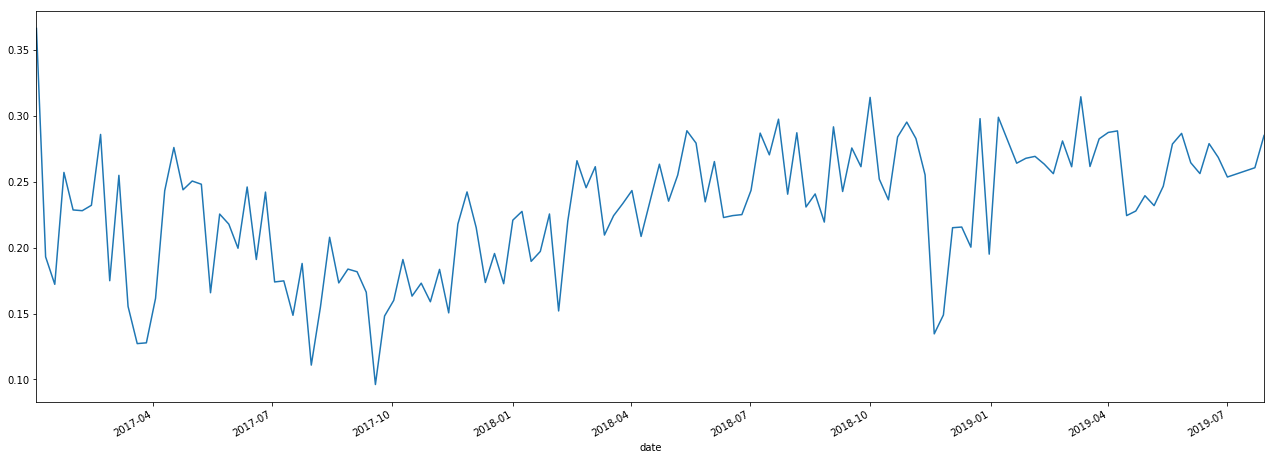

In [109]:
bitcoin_sentiment_weekly = get_weekly_mean(bitcoin_dataset)

> Bitcoin seems to be enjoying a bit of an upwards trend in their Twitter sentiment since it hit the 5 figure price-point in the fall of 2017

135
133


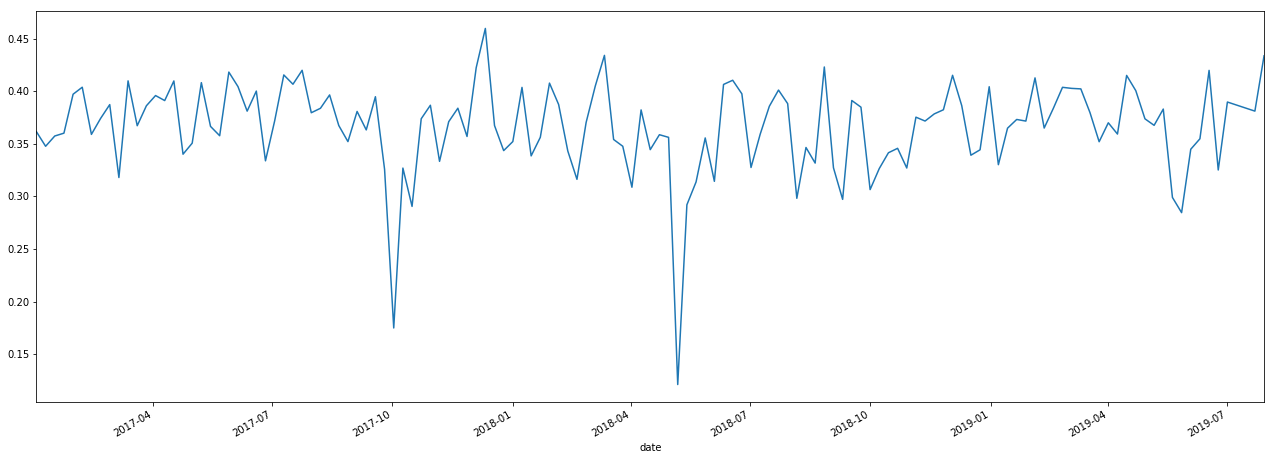

In [105]:
adidas_sentiment_weekly = get_weekly_mean(adidas_dataset)

> Since early 2018, Adidas' Twitter sentiment seems to be on a fairly steady rise, maybe their sustainability efforts have something to do with that

135
133


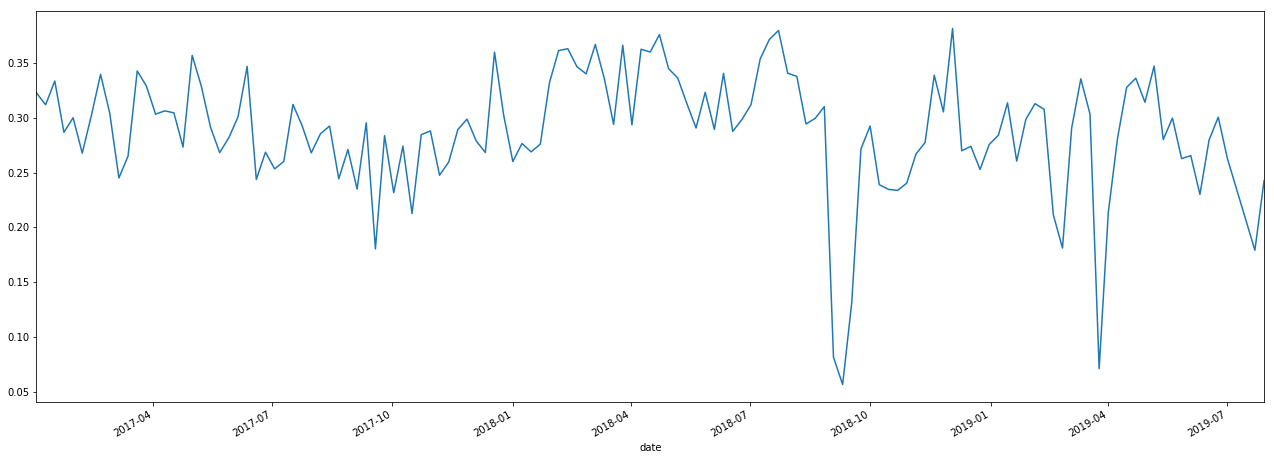

In [106]:
nike_sentiment_weekly = get_weekly_mean(nike_dataset)

> Look at Nike's Twitter sentiment September 2018, remember the boycott over their Colin Kaepernick Ad?

## Stationarity - Key concepts in Time Series Forecasting

Time Series predictions are dependent upon stationary data.  
Stationarity of data refers to consistency in the mean, variance, and covariance of the data over the period of time it is observed.
See the illustrations below:  


This is one of the most key concepts to undersand and correclty implement in Time Series data analysis - failure to do so may result in inconsistant results.  
Though the Adidas and Nike sentiments seem pretty stationary, we'll run a _Dickey-Fuller_ test as well as analyze the rolling mean and rolling standard deviation to more accurately measure Stationarity.  We will preprocess all of our sentiment score series to achieve optimal stationarity before computing our forecasts.  

We will do this using the `log transformation`, then `deseasonalization` and finally by `scaling` the data.  We will also consider `first differences` for removing the component of trend in the data.  

In [111]:
from statsmodels.tsa.stattools import adfuller

In [112]:
def test_stationarity(timeseries):
    """
    Takes in a Time Series and plots data with rolling mean + rolling standard deviation 
    Prints out results of Dickey-Fuller Test
    """
    #Determining rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(22, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

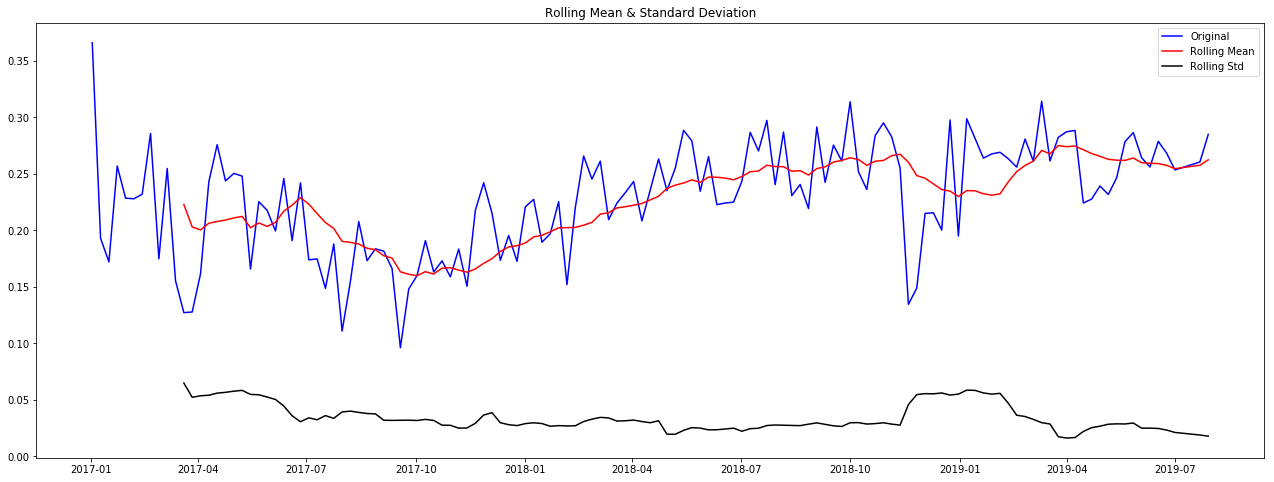

Results of Dickey-Fuller Test:
Test Statistic                  -1.170294
p-value                          0.686242
#Lags Used                      10.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


In [113]:
test_stationarity(bitcoin_sentiment_weekly['sentiment_score'])

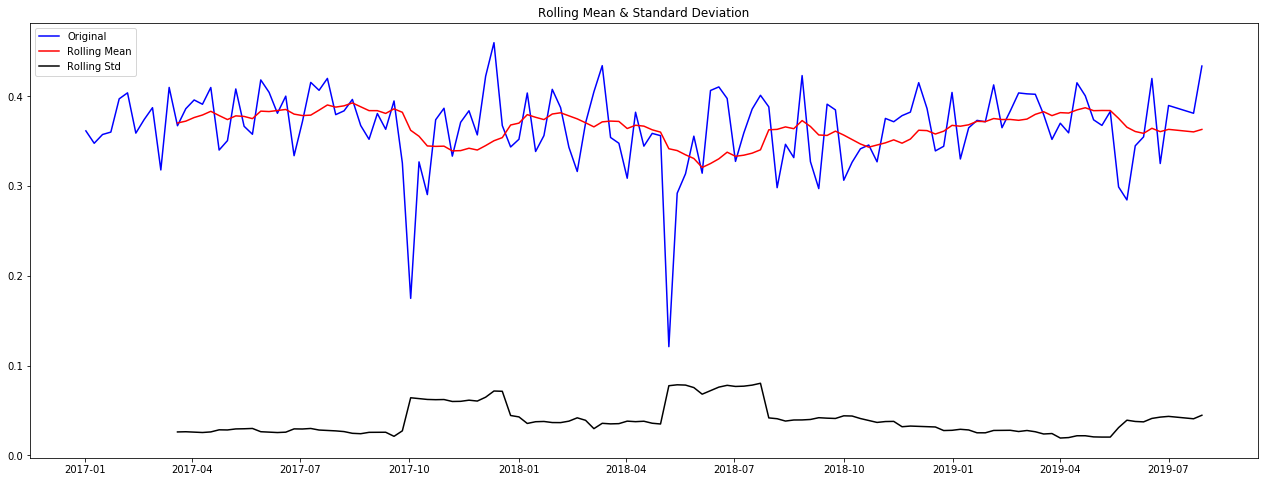

Results of Dickey-Fuller Test:
Test Statistic                -8.588270e+00
p-value                        7.404900e-14
#Lags Used                     0.000000e+00
Number of Observations Used    1.320000e+02
Critical Value (1%)           -3.480888e+00
Critical Value (5%)           -2.883697e+00
Critical Value (10%)          -2.578586e+00
dtype: float64


In [114]:
test_stationarity(adidas_sentiment_weekly['sentiment_score'])

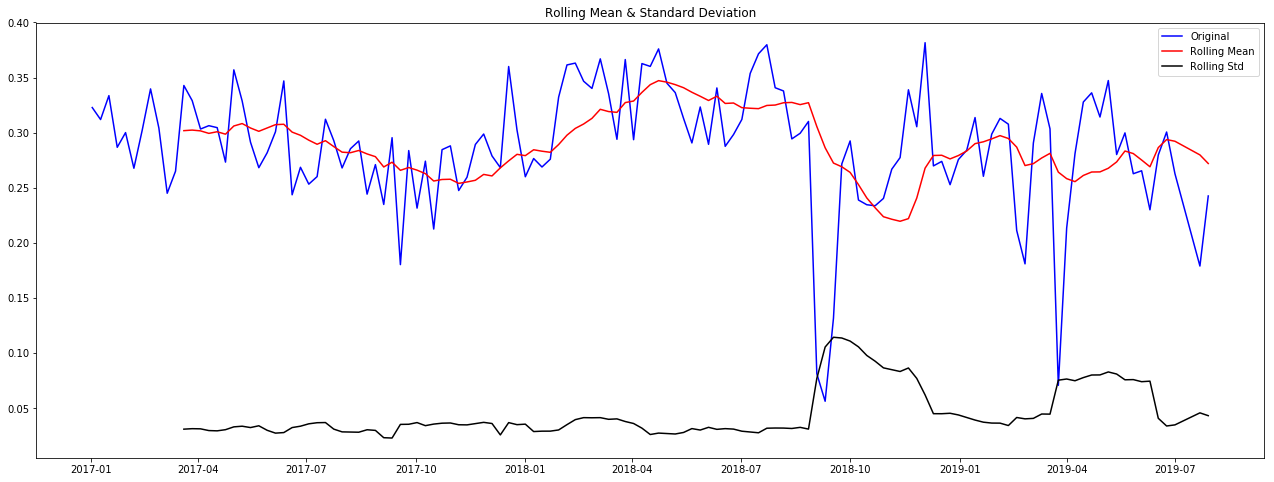

Results of Dickey-Fuller Test:
Test Statistic                  -3.554769
p-value                          0.006687
#Lags Used                       3.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [115]:
test_stationarity(nike_sentiment_weekly['sentiment_score'])

> Let's start with`log transformation`, `first differences`, then `deseasonalization` (seanonal differances) for the bitcoin data.  
> We will test stationarity with each step

In [130]:
def stationarity(df):
    """
    Takes a Time Series (df) and adds the following stationarity features for Time Series Modeling
    1. log_sentiment_score
    2. first_difference
    3. log_first_difference
    4. seasonal_difference
    5. log_seasonal_difference
    6. seasonal_first_difference
    7. log_seasonal_first_difference
    Performs a Dickey-Fuller for Stationarity on each feature
    """
    
    print('\n\n log_sentiment_score analysis:')
    df['log_sentiment_score'] = df.sentiment_score.apply(lambda x: np.log(x))  
    test_stationarity(df.log_sentiment_score)
    
    print('\n\n first_difference analysis:')
    df['first_difference'] = df.sentiment_score - df.sentiment_score.shift(1)  
    test_stationarity(df.first_difference.dropna(inplace=False))
    
    print('\n\n log_first_difference analysis:')
    df['log_first_difference'] = df.log_sentiment_score - df.log_sentiment_score.shift(1)  
    test_stationarity(df.log_first_difference.dropna(inplace=False))
    
    print('\n\n seasonal_difference analysis:')
    df['seasonal_difference'] = df.sentiment_score - df.sentiment_score.shift(12)  
    test_stationarity(df.seasonal_difference.dropna(inplace=False))
    
    print('\n\n log_seasonal_difference analysis:')
    df['log_seasonal_difference'] = df.log_sentiment_score - df.log_sentiment_score.shift(12)  
    test_stationarity(df.log_seasonal_difference.dropna(inplace=False))
    
    print('\n\n seasonal_first_difference analysis:')
    df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)  
    test_stationarity(df.seasonal_first_difference.dropna(inplace=False))
    
    print('\n\n log_seasonal_first_difference analysis:')
    df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)  
    test_stationarity(df.log_seasonal_first_difference.dropna(inplace=False))
    
    return df

# Bitcoin Stationarity



 log_sentiment_score analysis:


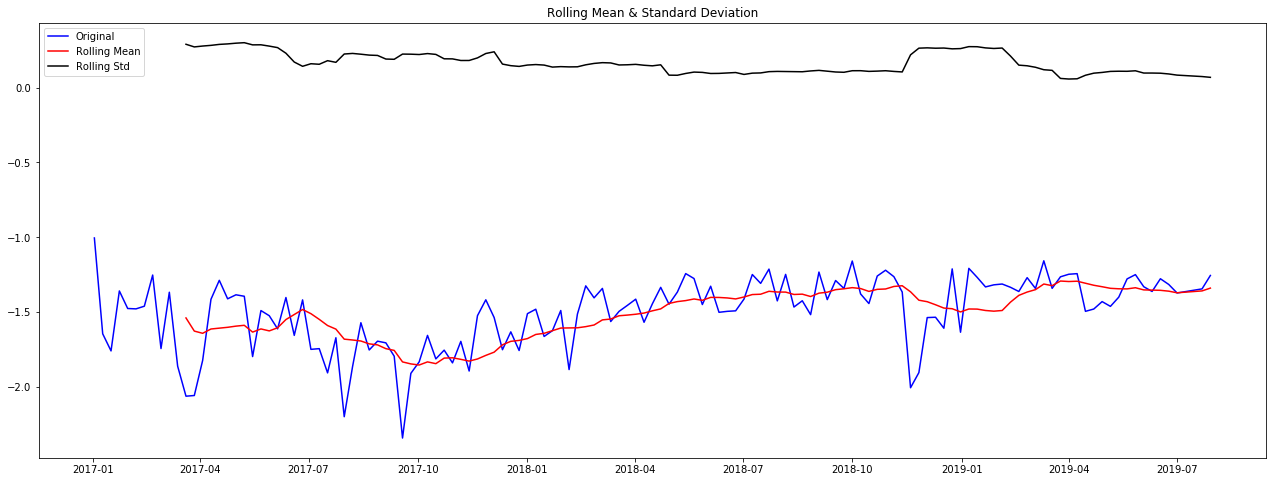

Results of Dickey-Fuller Test:
Test Statistic                  -1.247346
p-value                          0.652904
#Lags Used                      10.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


 first_difference analysis:


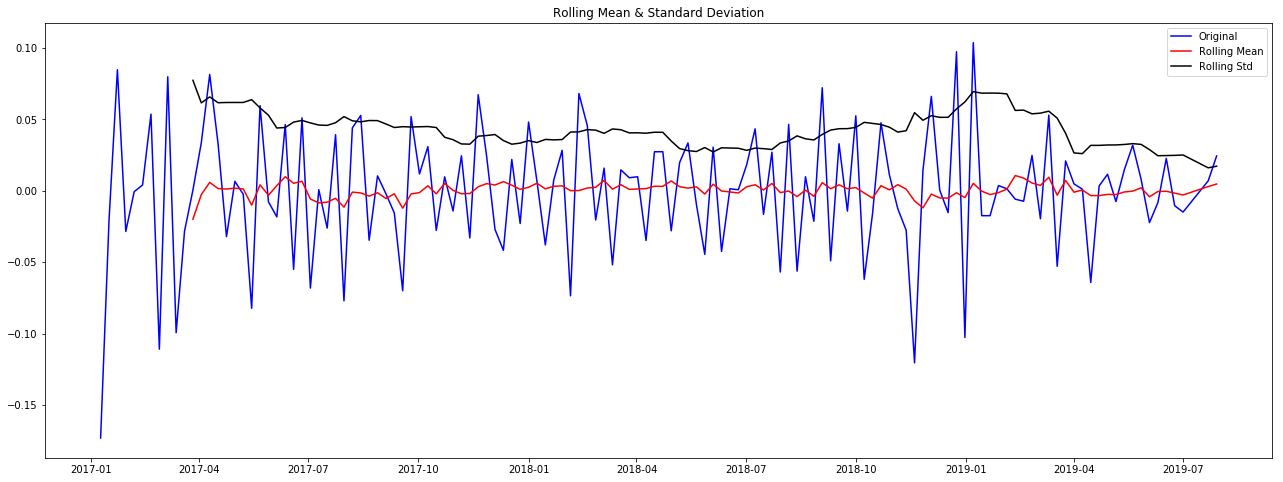

Results of Dickey-Fuller Test:
Test Statistic                  -5.555905
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


 log_first_difference analysis:


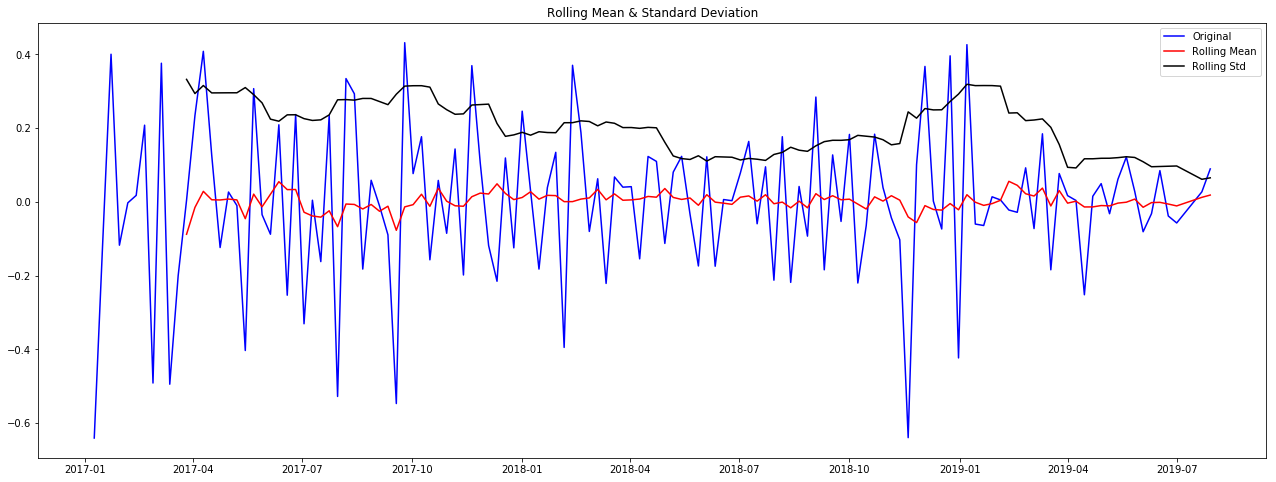

Results of Dickey-Fuller Test:
Test Statistic                  -5.628882
p-value                          0.000001
#Lags Used                       9.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


 seasonal_difference analysis:


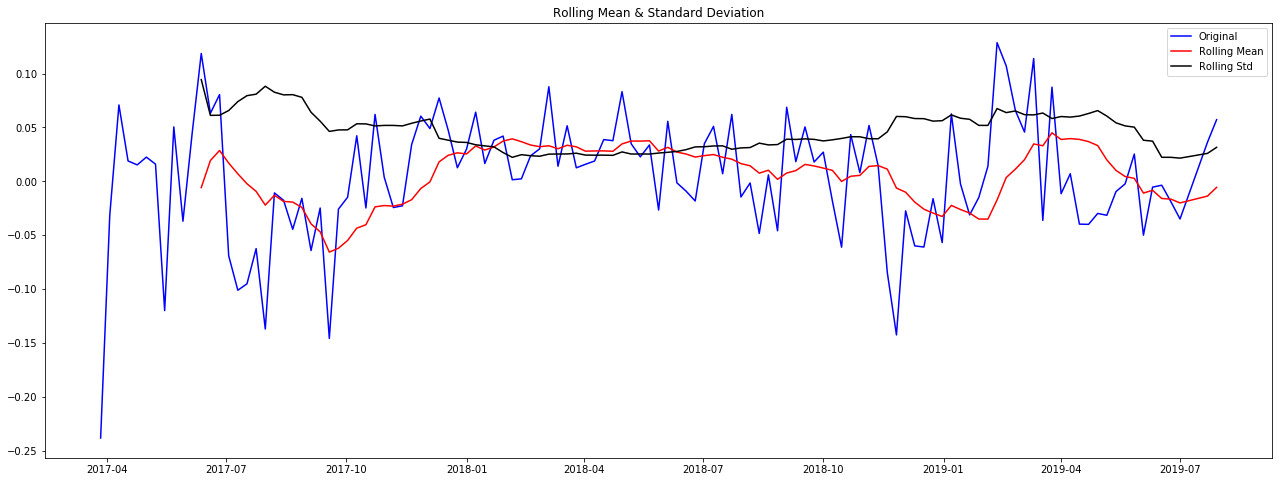

Results of Dickey-Fuller Test:
Test Statistic                  -2.559556
p-value                          0.101648
#Lags Used                      13.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


 log_seasonal_difference analysis:


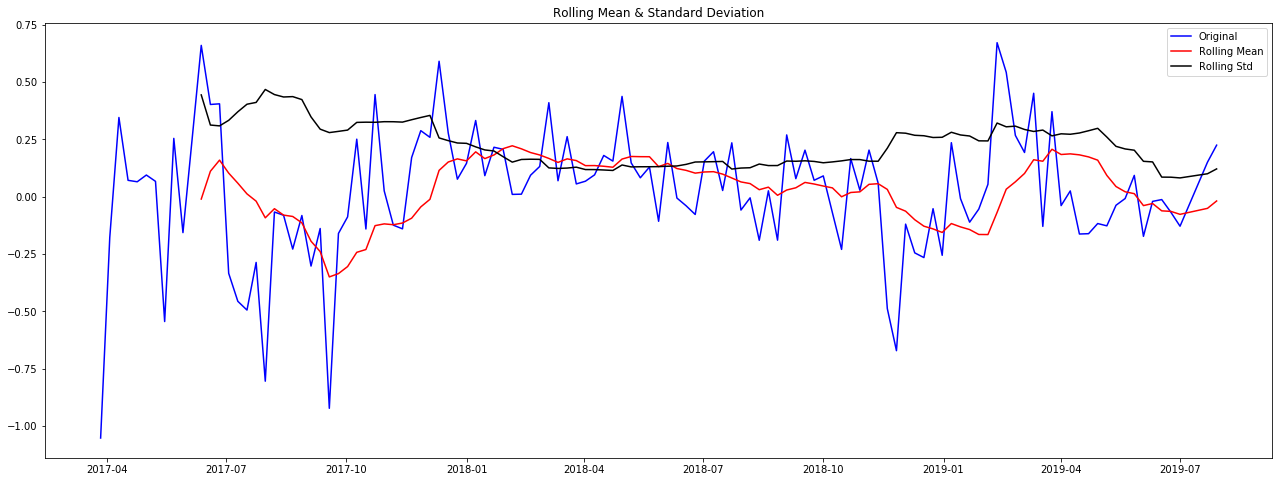

Results of Dickey-Fuller Test:
Test Statistic                  -2.644003
p-value                          0.084239
#Lags Used                      13.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


 seasonal_first_difference analysis:


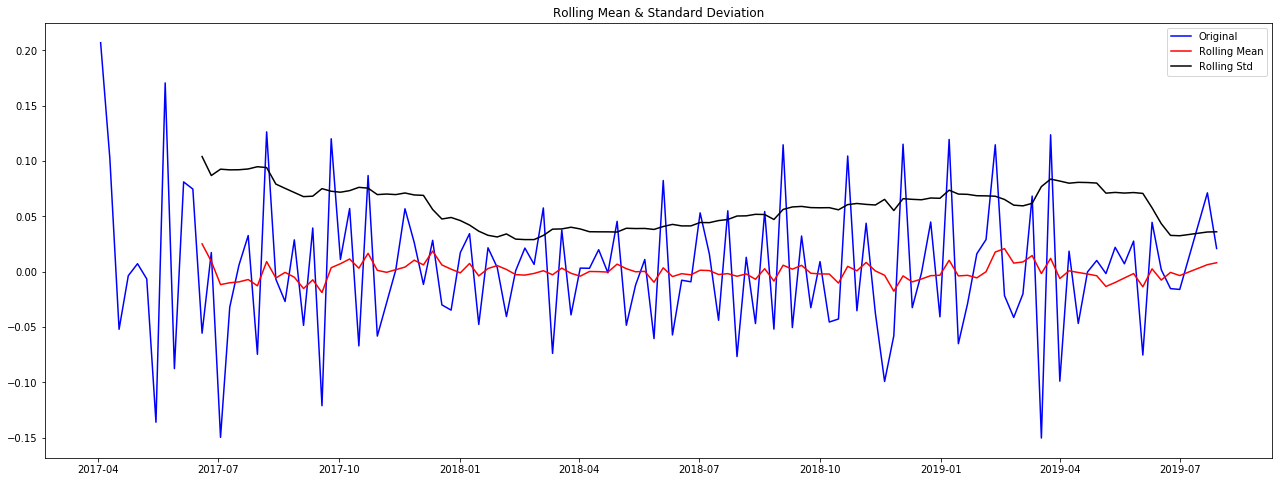

Results of Dickey-Fuller Test:
Test Statistic                  -4.598311
p-value                          0.000130
#Lags Used                      12.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


 log_seasonal_first_difference analysis:


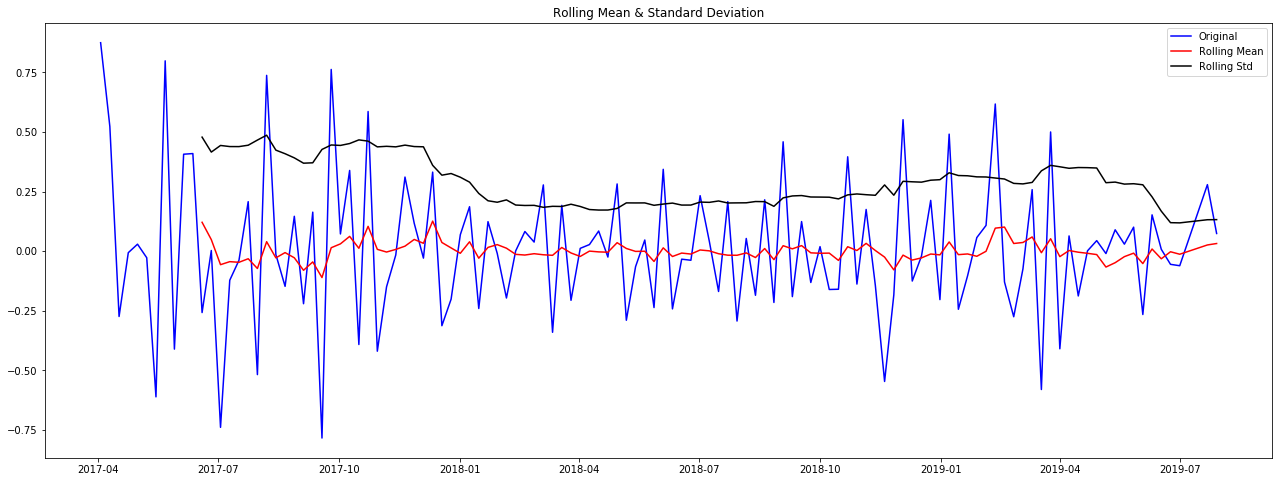

Results of Dickey-Fuller Test:
Test Statistic                  -4.536738
p-value                          0.000169
#Lags Used                      12.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [131]:
bitcoin_stationary = stationarity(bitcoin_sentiment_weekly)

> It looks like `log_first_difference` is our best bet for stationarity here

In [133]:
import statsmodels as sm

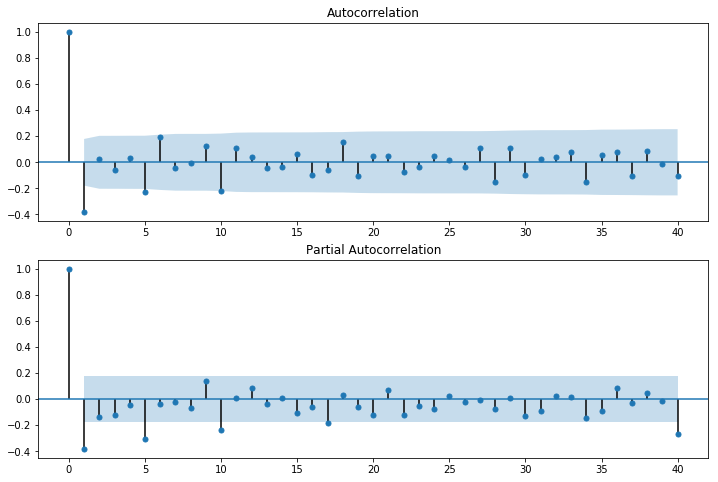

In [143]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsaplots.plot_acf(bitcoin_stationary.log_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsaplots.plot_pacf(bitcoin_stationary.log_first_difference.iloc[13:], lags=40, ax=ax2)

# Adidas Stationarity



 log_sentiment_score analysis:


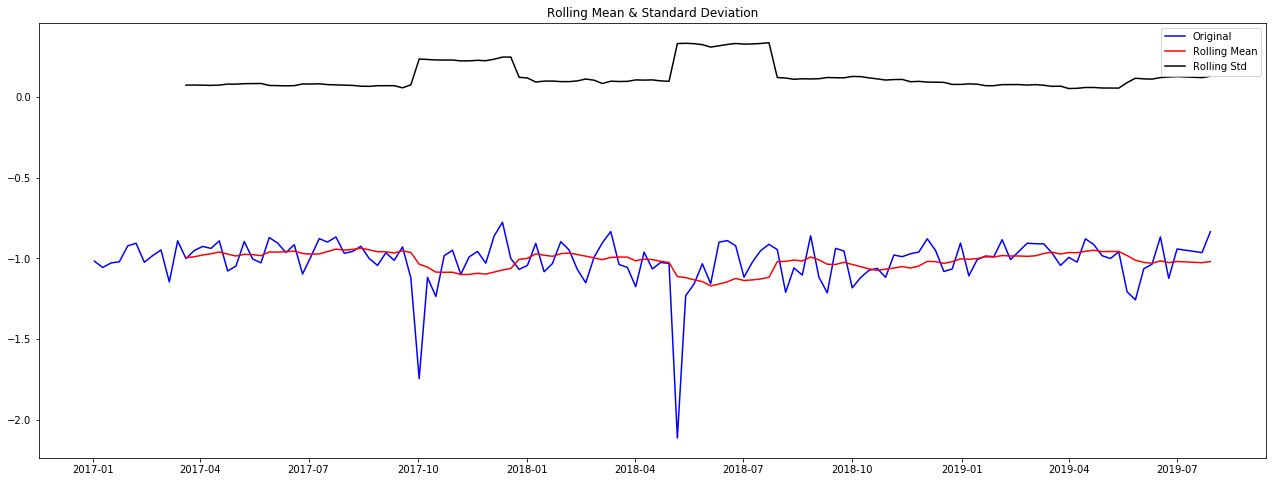

Results of Dickey-Fuller Test:
Test Statistic                -8.978354e+00
p-value                        7.425625e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.320000e+02
Critical Value (1%)           -3.480888e+00
Critical Value (5%)           -2.883697e+00
Critical Value (10%)          -2.578586e+00
dtype: float64


 first_difference analysis:


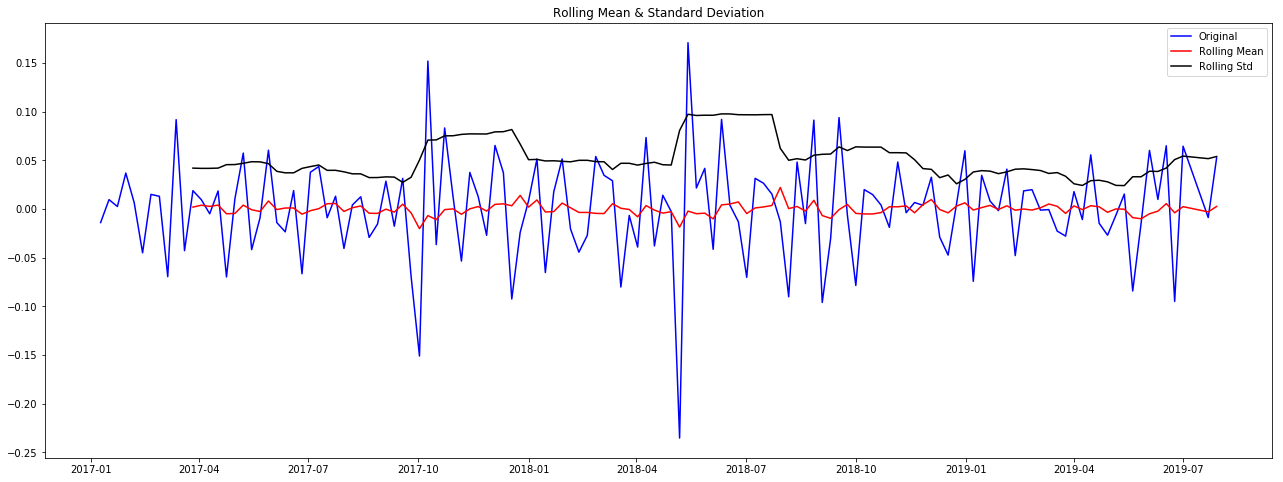

Results of Dickey-Fuller Test:
Test Statistic                -5.769697e+00
p-value                        5.428435e-07
#Lags Used                     1.100000e+01
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64


 log_first_difference analysis:


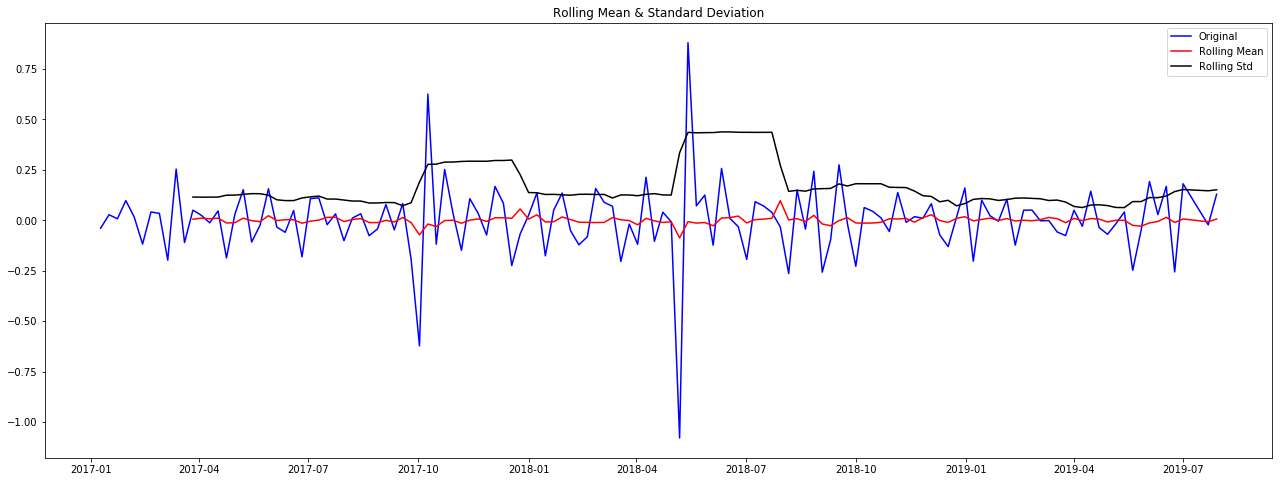

Results of Dickey-Fuller Test:
Test Statistic                -9.297818e+00
p-value                        1.133568e-15
#Lags Used                     3.000000e+00
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


 seasonal_difference analysis:


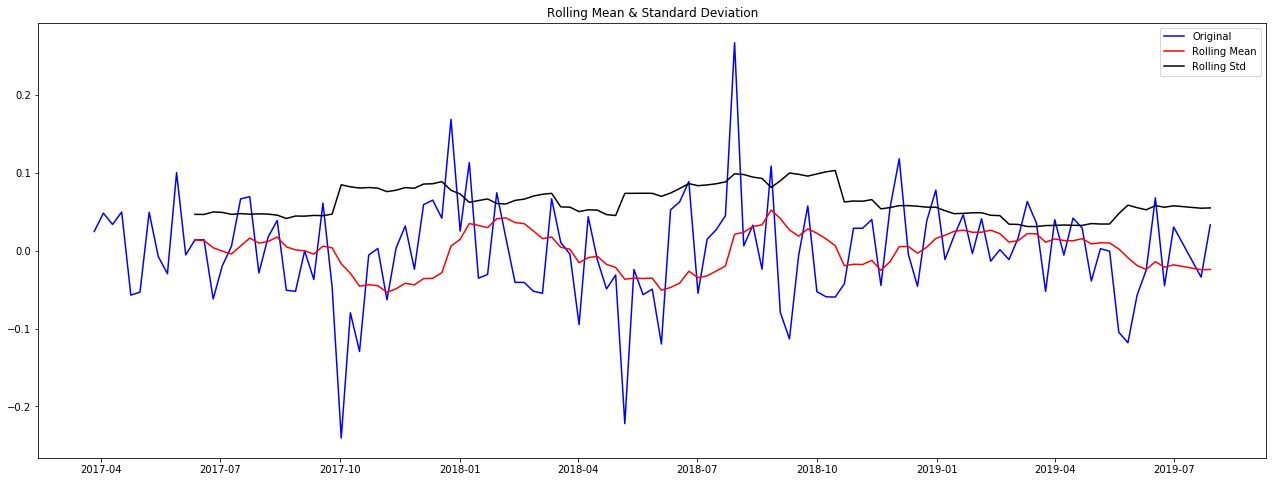

Results of Dickey-Fuller Test:
Test Statistic                  -3.142887
p-value                          0.023538
#Lags Used                      13.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


 log_seasonal_difference analysis:


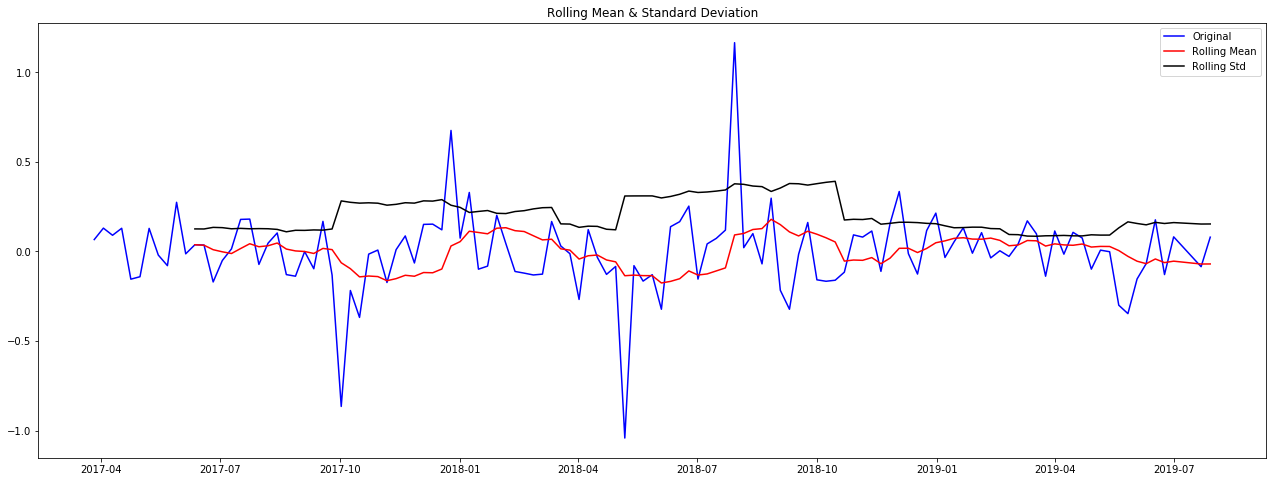

Results of Dickey-Fuller Test:
Test Statistic                  -4.174751
p-value                          0.000727
#Lags Used                      12.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


 seasonal_first_difference analysis:


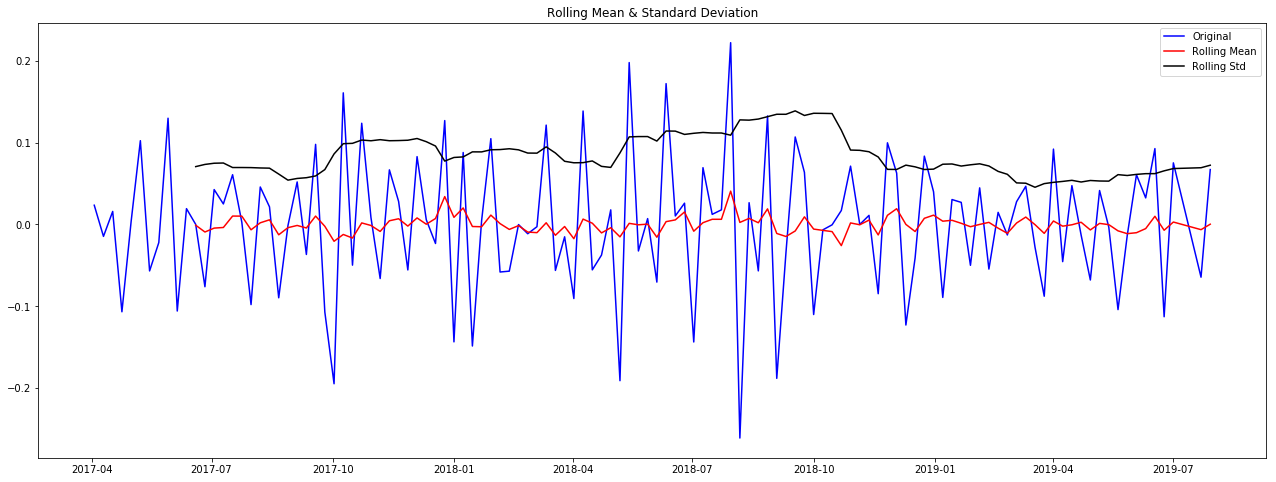

Results of Dickey-Fuller Test:
Test Statistic                  -5.546403
p-value                          0.000002
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


 log_seasonal_first_difference analysis:


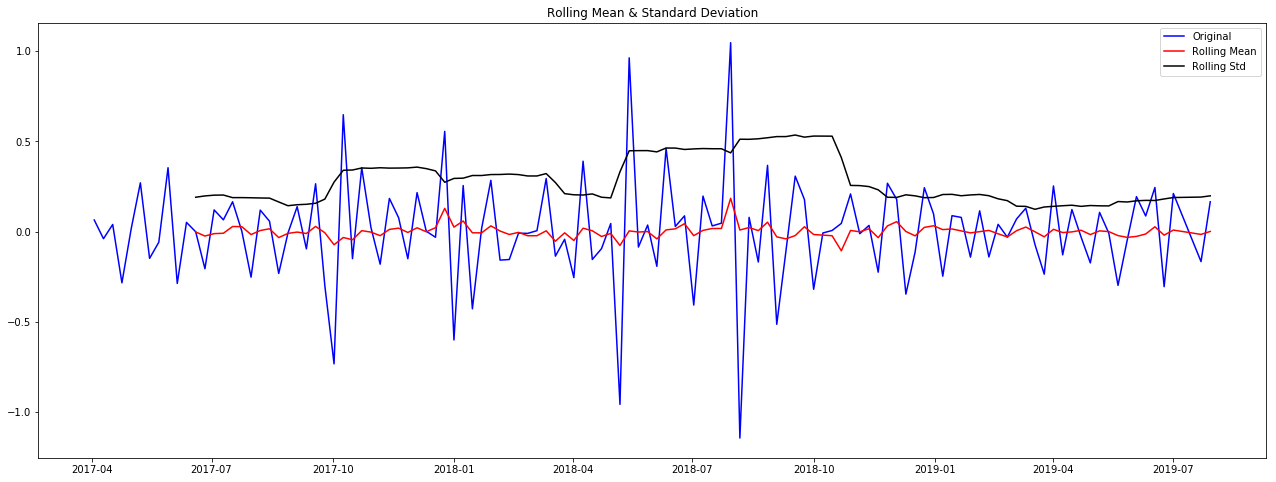

Results of Dickey-Fuller Test:
Test Statistic                  -5.360527
p-value                          0.000004
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [132]:
adidas_stationary = stationarity(adidas_sentiment_weekly)

> The `seasonal_first_difference` is the most stationary visually with the lowest P-value

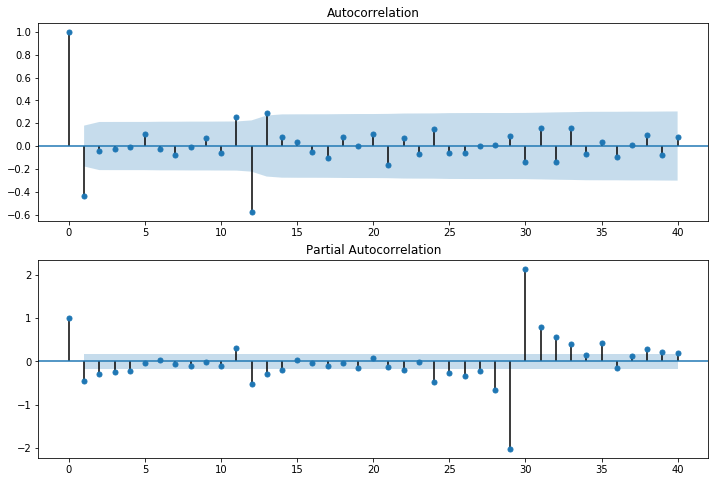

In [151]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsaplots.plot_acf(adidas_stationary.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsaplots.plot_pacf(adidas_stationary.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

# Nike Stationarity



 log_sentiment_score analysis:


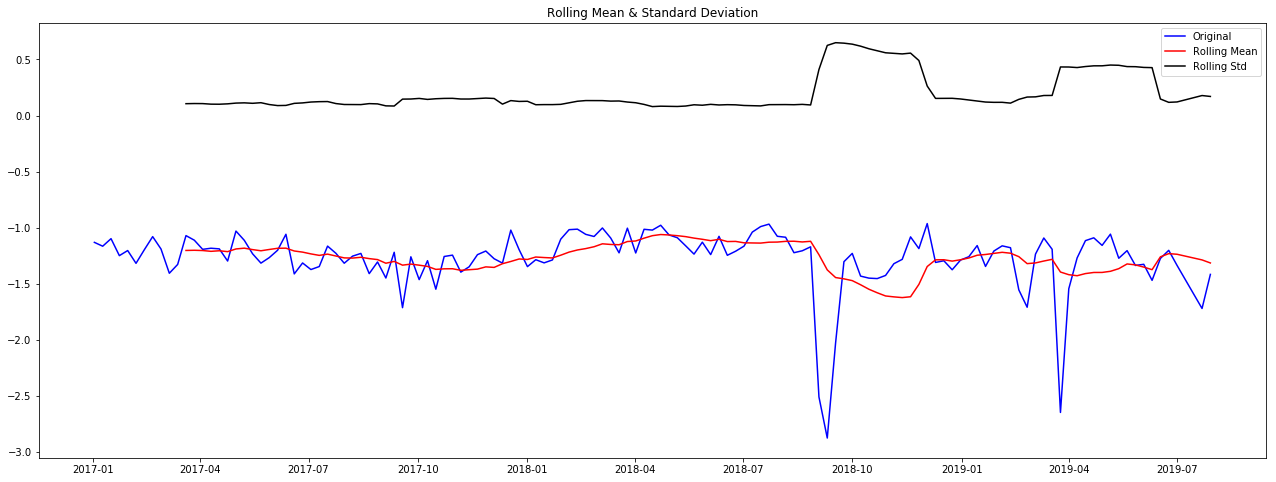

Results of Dickey-Fuller Test:
Test Statistic                  -3.988761
p-value                          0.001471
#Lags Used                       3.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


 first_difference analysis:


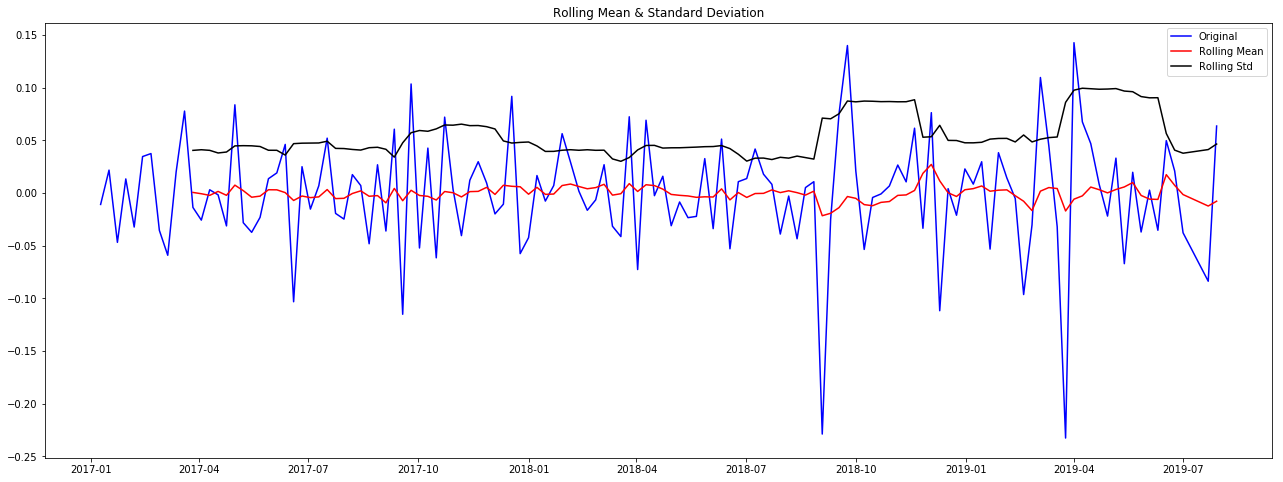

Results of Dickey-Fuller Test:
Test Statistic                -1.162572e+01
p-value                        2.326268e-21
#Lags Used                     2.000000e+00
Number of Observations Used    1.290000e+02
Critical Value (1%)           -3.482088e+00
Critical Value (5%)           -2.884219e+00
Critical Value (10%)          -2.578864e+00
dtype: float64


 log_first_difference analysis:


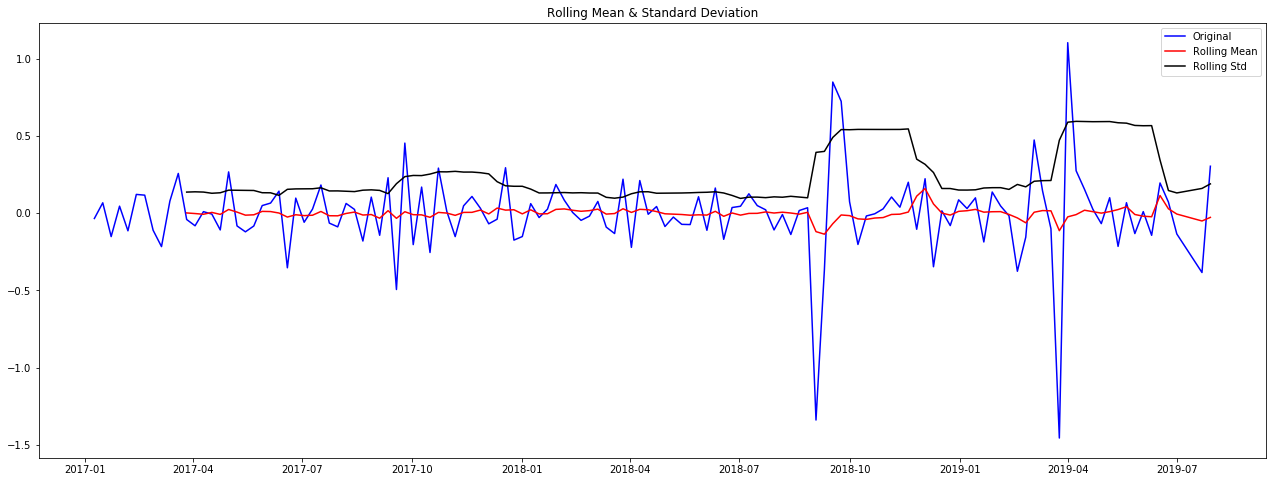

Results of Dickey-Fuller Test:
Test Statistic                -1.148205e+01
p-value                        4.967165e-21
#Lags Used                     2.000000e+00
Number of Observations Used    1.290000e+02
Critical Value (1%)           -3.482088e+00
Critical Value (5%)           -2.884219e+00
Critical Value (10%)          -2.578864e+00
dtype: float64


 seasonal_difference analysis:


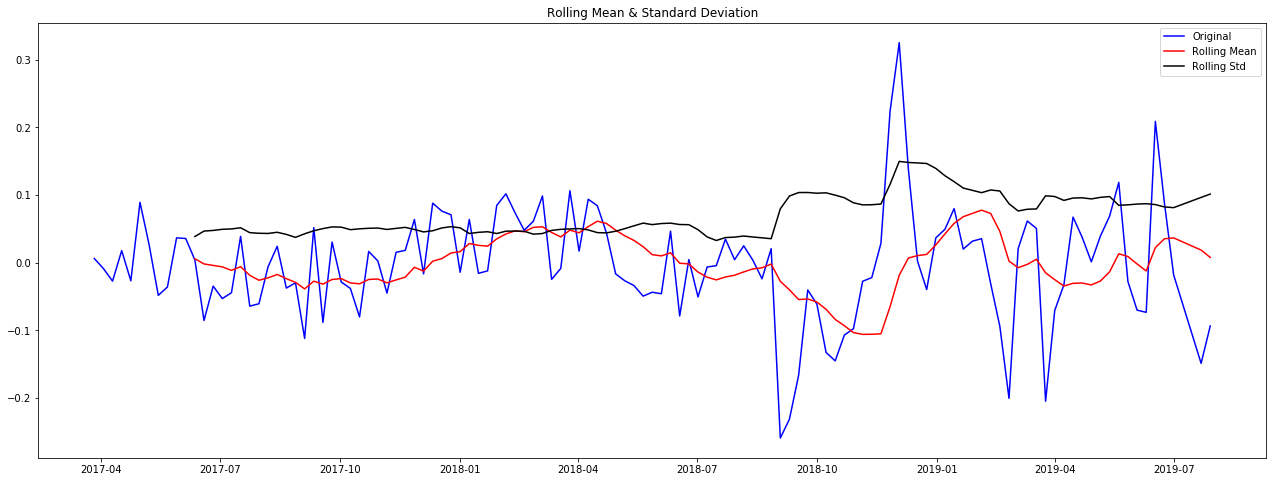

Results of Dickey-Fuller Test:
Test Statistic                  -2.138044
p-value                          0.229495
#Lags Used                      13.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


 log_seasonal_difference analysis:


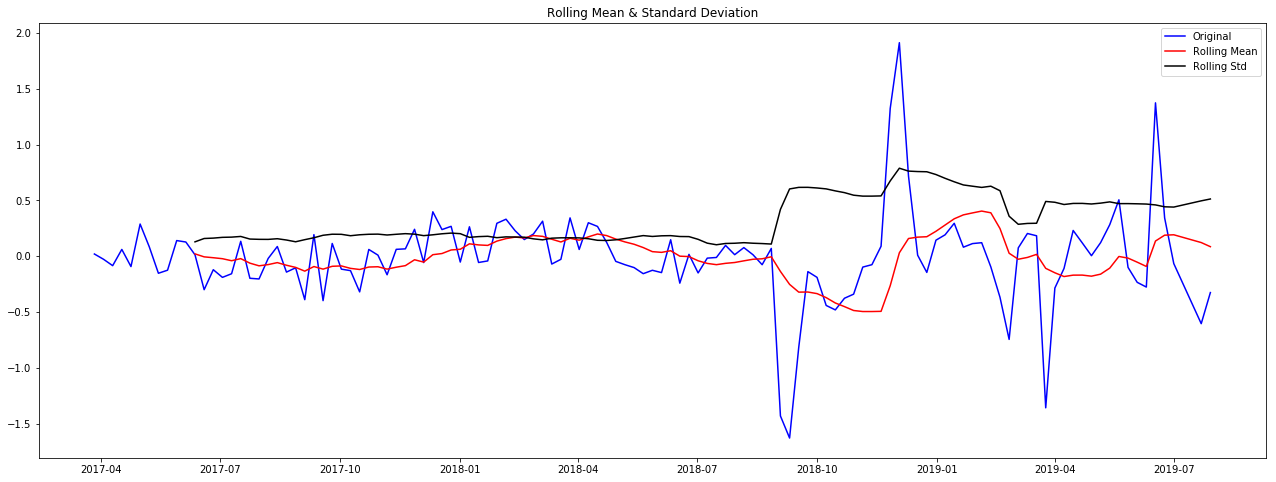

Results of Dickey-Fuller Test:
Test Statistic                  -3.299604
p-value                          0.014896
#Lags Used                      12.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


 seasonal_first_difference analysis:


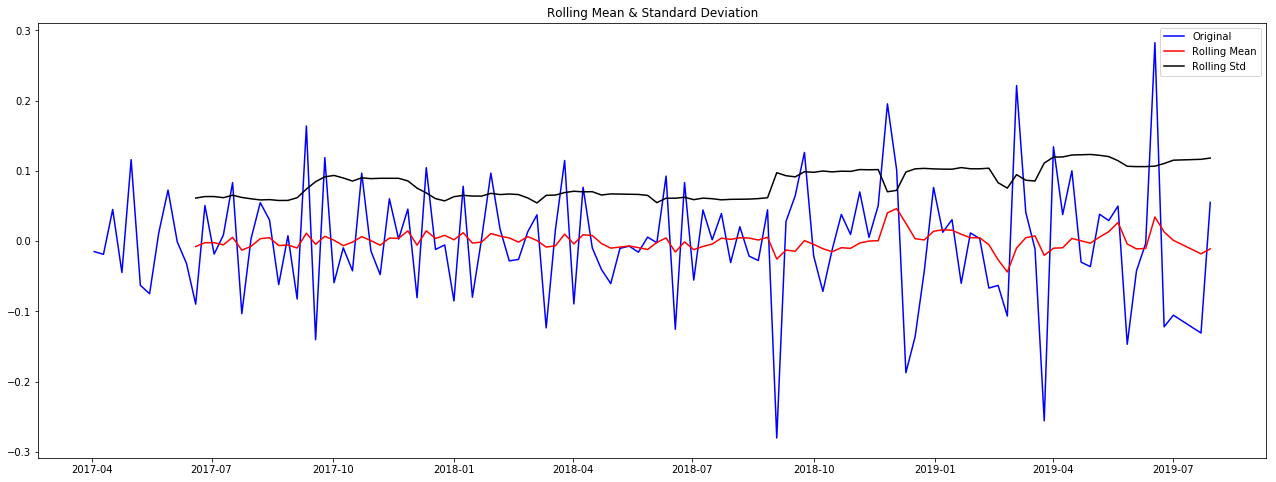

Results of Dickey-Fuller Test:
Test Statistic                  -4.479305
p-value                          0.000214
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


 log_seasonal_first_difference analysis:


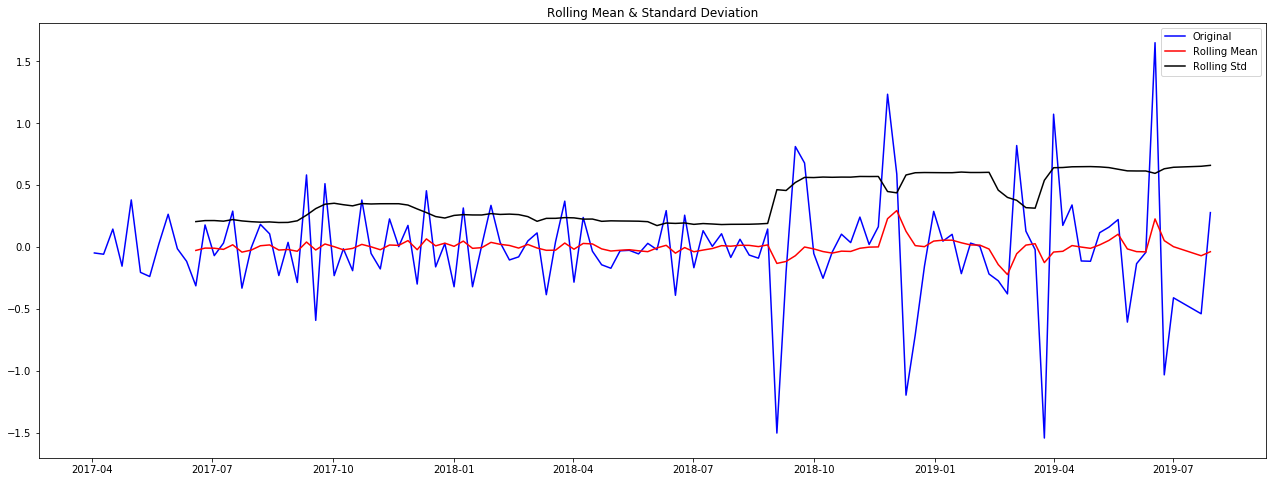

Results of Dickey-Fuller Test:
Test Statistic                  -5.263642
p-value                          0.000007
#Lags Used                      12.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [129]:
nike_stationary = stationarity(nike_sentiment_weekly)

> the `log_seasonal_first_difference` feature seems the most stationary visually and also has the lowest P-value.  Additionally, his feature is the most expanded in terms of value range.  It may make sense to fit our model on this data.  (remember we have yet to scale the data)

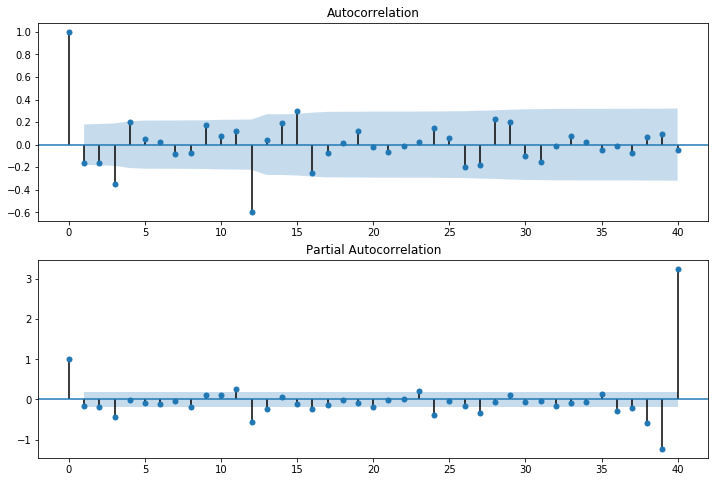

In [150]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsaplots.plot_acf(nike_stationary.log_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsaplots.plot_pacf(nike_stationary.log_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

### scaling and normalizing time series.  

# 7 . Introducing Time Series Modeling

Now that we have a few stationarity features to choose from when training our model, let's try a SARIMAX model and pass it a variety of params to test

In [159]:
import statsmodels.api as sm

In [277]:
def fit_pretict_SARIMAX(search_term, df, trend='n', order=(0,1,0), seasonal_order=(1,1,1,18)):
    """
    Takes twiiter search term, corresponding stationary/scaled dataframe, and SARIMAX params (set to default)
    Fits model, prints out model summary stats, and predicts test forecast, 
    Plots sentiment_score against test forecast
    Saves .png of the comparison plot
    Returns digit-indexed df with 'forecast' feature for accuracy measurement & comparison 
    """
    # fit model
    model = sm.tsa.statespace.SARIMAX(df.sentiment_score, trend=trend, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    print(results.summary())
    # predict and plot
    df_digit_index = df.reset_index()
    df_digit_index['forecast'] = results.predict(start = 113, end= 233, dynamic= True)  
    df_digit_index[['sentiment_score', 'forecast']].plot(figsize=(12, 8)) 
    plt.savefig(search_term + '_SARIMAX_sentiment_predict.png', bbox_inches='tight')
    
    return df_digit_index
    
    

/Users/Frankie/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                    sentiment_score   No. Observations:                  133
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                 186.084
Date:                            Wed, 31 Jul 2019   AIC                           -368.167
Time:                                    20:44:04   BIC                           -362.592
Sample:                                         0   HQIC                          -365.903
                                            - 133                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9529      0.427     -2.229      0.026      -1.791      -0.115
sigma2         0.0022      0.001   

/Users/Frankie/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


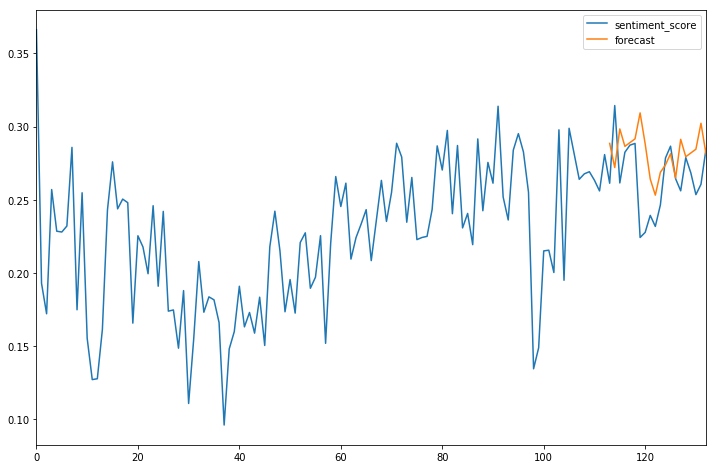

In [278]:
bitcoin_forecast_test = fit_pretict_SARIMAX('bitcoin', bitcoin_stationary, seasonal_order=(0,1,1,12))

/Users/Frankie/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                    sentiment_score   No. Observations:                  133
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 18)   Log Likelihood                 158.098
Date:                            Wed, 31 Jul 2019   AIC                           -312.197
Time:                                    20:16:58   BIC                           -306.725
Sample:                                         0   HQIC                          -309.976
                                            - 133                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L18      -0.9842      3.578     -0.275      0.783      -7.997       6.029
sigma2         0.0027      0.010   

/Users/Frankie/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


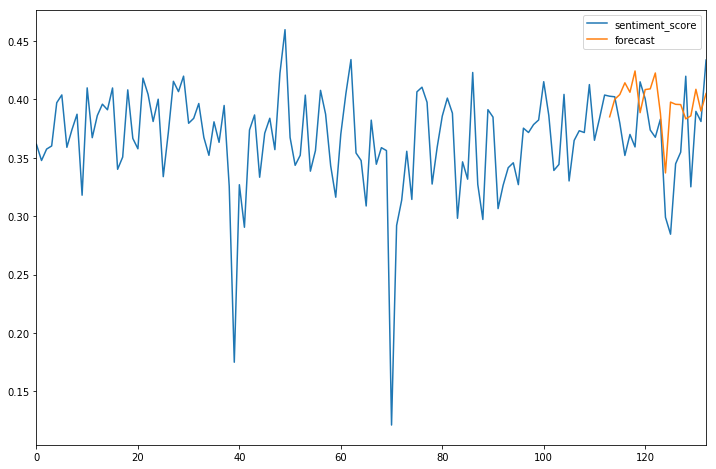

In [272]:
adidas_forecast_test = fit_pretict_SARIMAX('adidas', adidas_stationary, seasonal_order=(0,1,1,18))

/Users/Frankie/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                    sentiment_score   No. Observations:                  133
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 14)   Log Likelihood                 179.718
Date:                            Wed, 31 Jul 2019   AIC                           -349.436
Time:                                    20:17:40   BIC                           -335.541
Sample:                                         0   HQIC                          -343.794
                                            - 133                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5699      0.155      3.683      0.000       0.267       0.873
ma.L1         -0.0564      0.170   

/Users/Frankie/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


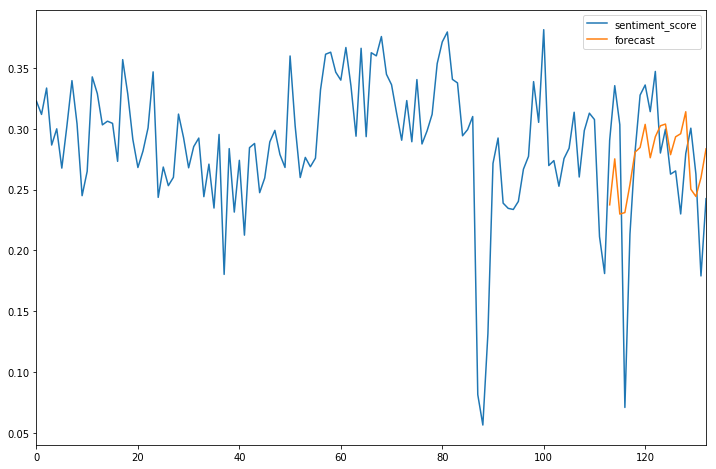

In [276]:
nike_forecast_test = fit_pretict_SARIMAX('nike', nike_stationary, order=(1,0,1), seasonal_order=(1,1,1,14))

# GridSearch

> Manually changing our model's params isn't much help.  Let's run a GridSearch on SARIMAX and get our optimal params per dataset

# 8 . Analysing prediction accuracy

In [ ]:
# sMAPE

In [ ]:
# MASE

Statistical and Machine Learning forecasting methods: Concerns and ways forward:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0194889

# 9 . Trend predictions on future perception

# 10 . Testing for Trends

# 11 . Conclusions and real world applications